# Thomas Jones - CS5530-0005 - Final Project

## Common Imports

In [267]:
import math

#analysis imports
import pandas as pd
from scipy import stats

#visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

#dataload imports
import requests
import io

from sklearn.metrics import mean_squared_error

#modeling
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold





#Evaluate the PCA of the data
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [268]:
#Model imports
from sklearn.linear_model import LinearRegression

#Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor




## Utility Functions

In [269]:
def get_train_test_data(df, target_column, test_size=0.2):
    X = df.drop(columns=[target_column])
    y = df[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    return X_train, X_test, y_train, y_test

def find_model_fit_selection(model, X_train, y_train, X_test, y_test):
    selector = RFECV(model, step=1, cv=KFold(5))
    selector = selector.fit(X_train, y_train)
    return selector, selector.score(X_test, y_test)


## Task 1 - Laptop Regression

### Dataload (Data Gathering)
Load the laptop csv

In [270]:

# Load the dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/laptop_prices.csv'
s = requests.get(url).content
df_laptops = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_laptops.head()

,Company,TypeName,Inches,Ram,OS,Weight,Price_euros,Screen,ScreenW,ScreenH,...,RetinaDisplay,CPU_company,CPU_freq,CPU_model,PrimaryStorage,SecondaryStorage,PrimaryStorageType,SecondaryStorageType,GPU_company,GPU_model
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,Standard,2560,1600,...,Yes,Intel,2.3,Core i5,128,0,SSD,No,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,Standard,1440,900,...,No,Intel,1.8,Core i5,128,0,Flash Storage,No,Intel,HD Graphics 6000
2,HP,Notebook,15.6,8,No OS,1.86,575.00,Full HD,1920,1080,...,No,Intel,2.5,Core i5 7200U,256,0,SSD,No,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,Standard,2880,1800,...,Yes,Intel,2.7,Core i7,512,0,SSD,No,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,Standard,2560,1600,...,Yes,Intel,3.1,Core i5,256,0,SSD,No,Intel,Iris Plus Graphics 650


### Data Cleaning

We will first take a look at the overall data to get a sense of the types and any missing values.

In [271]:
#Show column data information
print(df_laptops.info())

#Show null counts for each column
print(df_laptops.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1275 entries, 0 to 1274
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1275 non-null   object 
 1   TypeName              1275 non-null   object 
 2   Inches                1275 non-null   float64
 3   Ram                   1275 non-null   int64  
 4   OS                    1275 non-null   object 
 5   Weight                1275 non-null   float64
 6   Price_euros           1271 non-null   float64
 7   Screen                1275 non-null   object 
 8   ScreenW               1275 non-null   int64  
 9   ScreenH               1275 non-null   int64  
 10  Touchscreen           1275 non-null   object 
 11  IPSpanel              1275 non-null   object 
 12  RetinaDisplay         1273 non-null   object 
 13  CPU_company           1275 non-null   object 
 14  CPU_freq              1274 non-null   float64
 15  CPU_model            

#### Data Cleaning Discussion
Since price is our target variable it does not make sense to impute those. Those entries should be dropped.

For RetinaDisplay, it is reasonable to assume that missing data means "no" so for those values we will use default values.

There is only a single value missing for CPU Frequency, as this is not significant compared to the total data size we will remove that row.

In [272]:
# Remove rows with missing Price_euros
df_laptops.dropna(subset=['Price_euros'], inplace=True)

# Fill missing values for RetinaDisplay with 'No'
df_laptops.fillna({'RetinaDisplay': 'No'}, inplace=True)

# Remove rows with missing CPU_freq
df_laptops.dropna(subset=['CPU_freq'], inplace=True)

# Finally, remove rows with missing values remaining
print(df_laptops.isna().sum())

#Just to get an idea of the data
print("Data shape: ", df_laptops.shape)


Company                 0
TypeName                0
Inches                  0
Ram                     0
OS                      0
Weight                  0
Price_euros             0
Screen                  0
ScreenW                 0
ScreenH                 0
Touchscreen             0
IPSpanel                0
RetinaDisplay           0
CPU_company             0
CPU_freq                0
CPU_model               0
PrimaryStorage          0
SecondaryStorage        0
PrimaryStorageType      0
SecondaryStorageType    0
GPU_company             0
GPU_model               0
dtype: int64
Data shape:  (1270, 22)


### Data Exploration
The laptop data contains a mix of category and numerical data. We'll start with the category data first to get an idea of what values are present for each category. To do this, we'll first split out the category columns.

In [273]:
#select the category columns from the dataframe
df_laptop_category_data = df_laptops.select_dtypes(include=['object'])

#Print the unique value counts for each category column
print(df_laptop_category_data.nunique())


Company                  19
TypeName                  6
OS                        9
Screen                    4
Touchscreen               3
IPSpanel                  2
RetinaDisplay             2
CPU_company               3
CPU_model                93
PrimaryStorageType        4
SecondaryStorageType      4
GPU_company               4
GPU_model               110
dtype: int64


#### CPU-GPU Models
One thing to notice is the large differences in counts of different types of CPUs and GPUs. These may be useful for predictive analysis later but that data won't fit very well on bar charts. It may be that there are a few types that dominate the counts, however, so we can evaluate them.

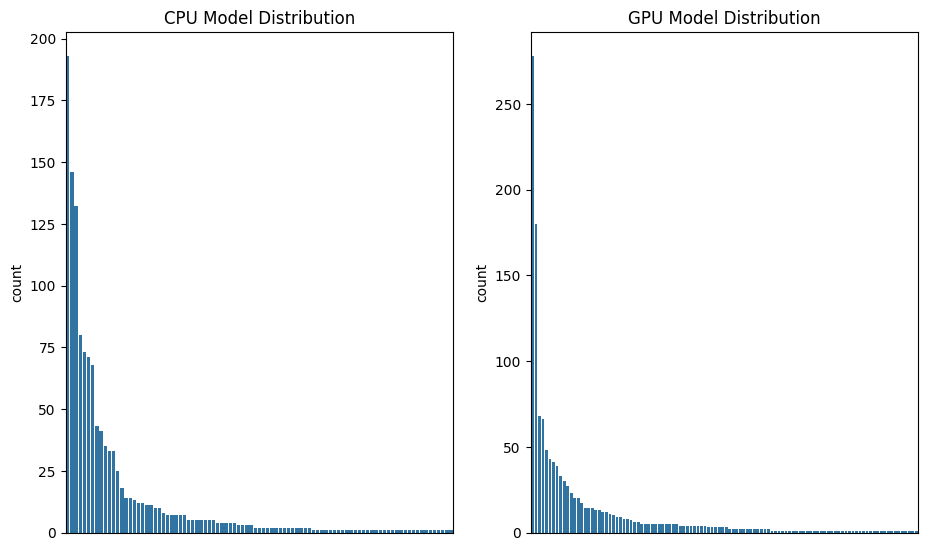

In [274]:
#Visualize the distribution of the CPU and GPU models
plt.rcParams["figure.figsize"] = [11.0, 6.50]
f, axs = plt.subplots(1, 2)

sns.countplot(data=df_laptops, x='CPU_model', order=df_laptops['CPU_model'].value_counts().index, ax=axs[0])
sns.countplot(data=df_laptops, x='GPU_model', order=df_laptops['GPU_model'].value_counts().index, ax=axs[1])
axs[0].set_xticks([])
axs[0].set_xlabel('')
axs[0].set_title('CPU Model Distribution')
axs[1].set_xticks([])
axs[1].set_xlabel('')
axs[1].set_title('GPU Model Distribution')
plt.show()

For the plot above we can see that there are a large number of CPU and GPU models that exist on the tails of the plots, i.e. there are a large number that have only a few values. We can group those together into an "other" category. This will allow us to utilize the model as a predictive characteristic for the more common cases.

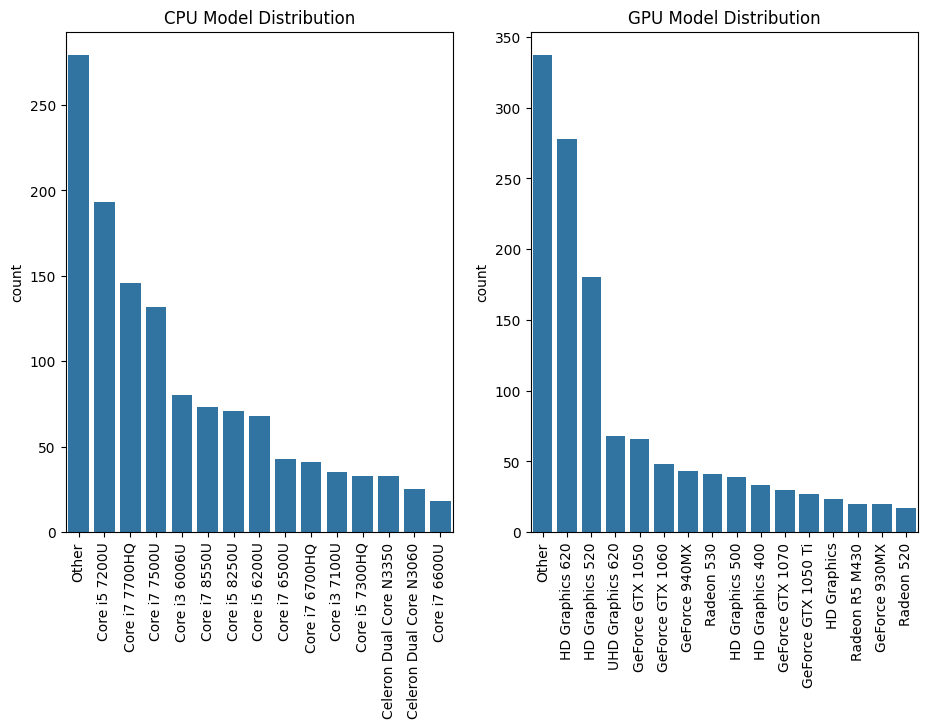

In [275]:
#Now we are going to create two new columns where any CPU/GPU model that appears less than 15 times will be replaced with 'Other'
df_laptops['CPU_model_adj'] = df_laptops['CPU_model'].apply(lambda x: x if df_laptops['CPU_model'].value_counts()[x] > 15 else 'Other')
df_laptops['GPU_model_adj'] = df_laptops['GPU_model'].apply(lambda x: x if df_laptops['GPU_model'].value_counts()[x] > 15 else 'Other')

#Now replot the CPU/GPU models
plt.rcParams["figure.figsize"] = [11.0, 6.50]
f, axs = plt.subplots(1, 2)

sns.countplot(data=df_laptops, x='CPU_model_adj', order=df_laptops['CPU_model_adj'].value_counts().index, ax=axs[0])
sns.countplot(data=df_laptops, x='GPU_model_adj', order=df_laptops['GPU_model_adj'].value_counts().index, ax=axs[1])
axs[0].set_xticks(axs[0].get_xticks())
axs[1].set_xticks(axs[1].get_xticks())
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[0].set_title('CPU Model Distribution')
axs[1].set_title('GPU Model Distribution')
plt.show()

Company                  19
TypeName                  6
OS                        9
Screen                    4
Touchscreen               3
IPSpanel                  2
RetinaDisplay             2
CPU_company               3
CPU_model                93
PrimaryStorageType        4
SecondaryStorageType      4
GPU_company               4
GPU_model               110
CPU_model_adj            15
GPU_model_adj            16
dtype: int64


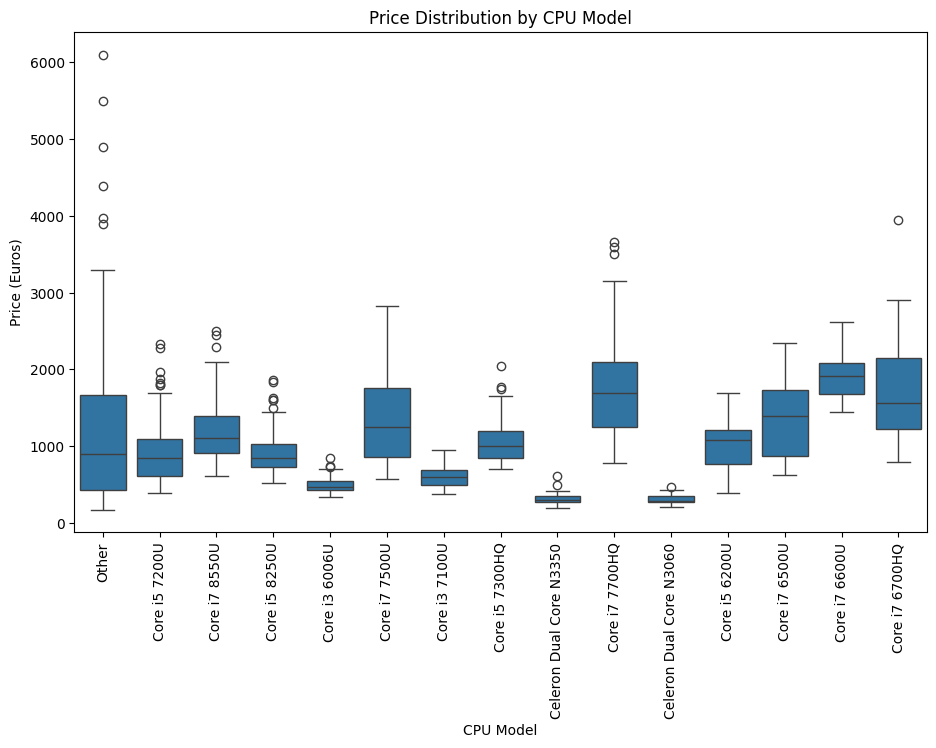

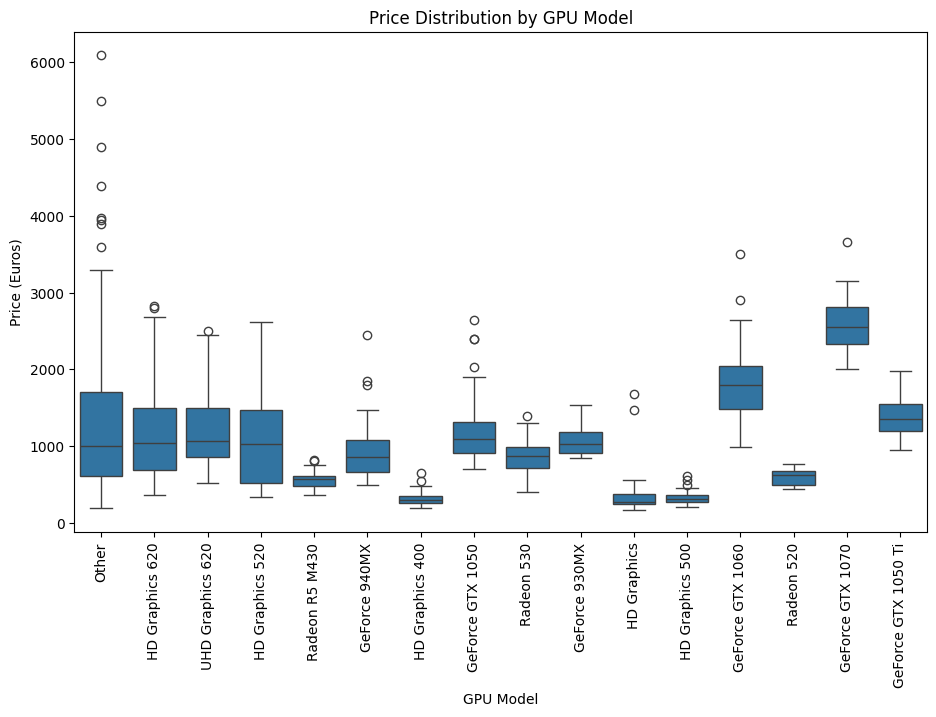

In [276]:
#Check our counts again
#select the category columns from the dataframe
df_laptop_category_data = df_laptops.select_dtypes(include=['object'])

print(df_laptop_category_data.nunique())

#Finally, let's look at the price data for the laptops for CPU and GPU models
sns.boxplot(data=df_laptops, x='CPU_model_adj', y='Price_euros')
plt.xticks(rotation=90)
plt.xlabel('CPU Model')
plt.ylabel('Price (Euros)')
plt.title('Price Distribution by CPU Model')
plt.show()

sns.boxplot(data=df_laptops, x='GPU_model_adj', y='Price_euros')
plt.xticks(rotation=90)
plt.xlabel('GPU Model')
plt.ylabel('Price (Euros)')
plt.title('Price Distribution by GPU Model')
plt.show()


The above graphs show us that there is some relationship between price and GPU model. Our "Other" category does show a few outliers but since these are singular values (other than the cluster around 4000), it's unlikely that there will be an enoremous effect on the regression model given the other features.

#### Remaining Categorical Data
We can also visualize the other categorical data across different categories. We can split it out by company.

Text(0.5, 1.0, 'Price Distribution by Company')

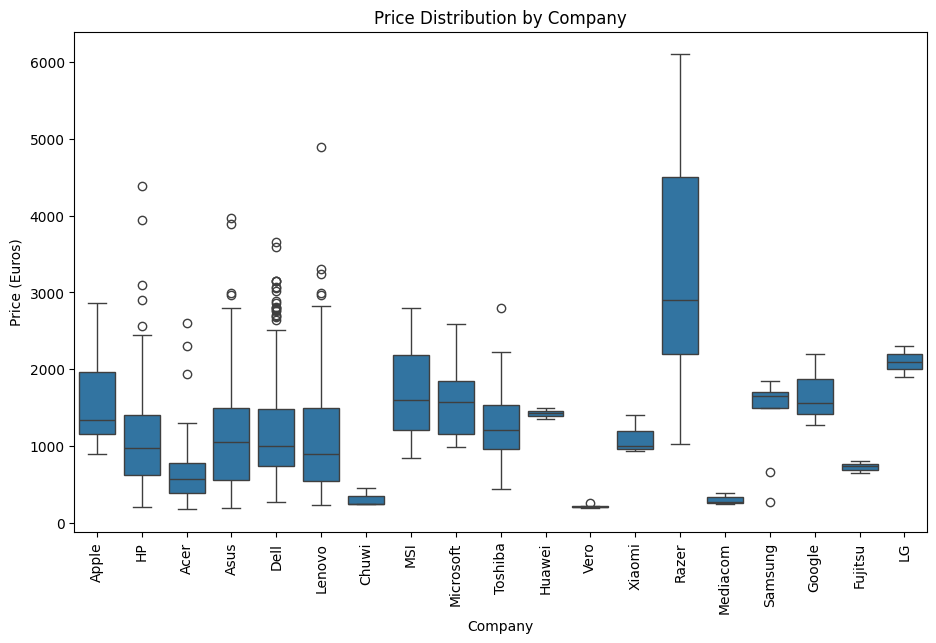

In [277]:
#First, do a boxplot of the Price_euros by Company
sns.boxplot(data=df_laptops, x='Company', y='Price_euros')
plt.xticks(rotation=90)
plt.xlabel('Company')
plt.ylabel('Price (Euros)')
plt.title('Price Distribution by Company')

We can see from the above plot that company can be an indicator of price. Since the remaining categories contain few values we can use a group of smaller plots.

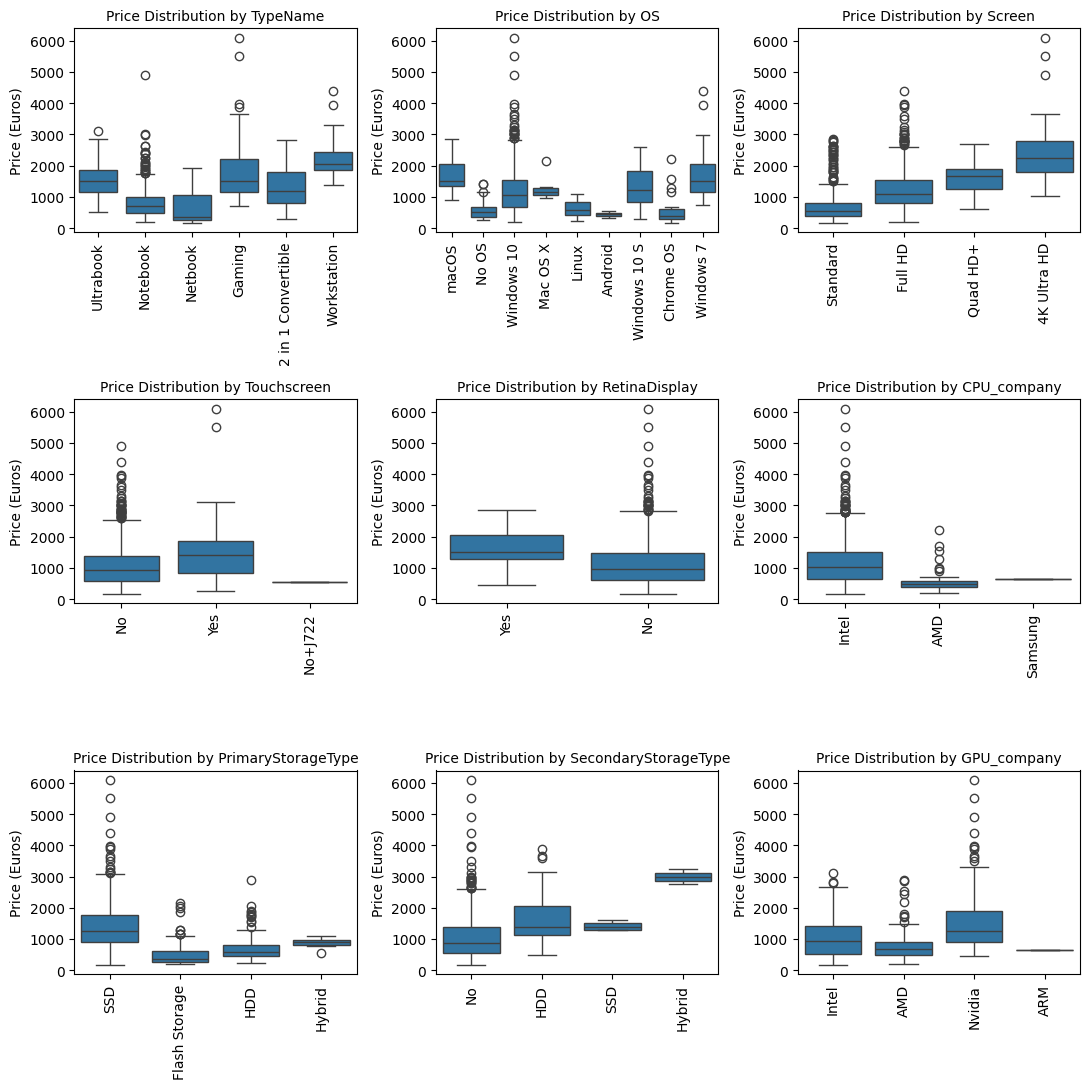

In [278]:
#Plot the Price_euros for the remaining categorical columns; TypeName, OS, Screen, Touchscreen, RetinaDisplay, CPU_company, PrimaryStorageType, SecondaryStorageType, GPU_company
plt.rcParams["figure.figsize"] = [11.0, 11.0]
f, axs = plt.subplots(3, 3)

sns.boxplot(data=df_laptops, x='TypeName', y='Price_euros', ax=axs[0, 0])
sns.boxplot(data=df_laptops, x='OS', y='Price_euros', ax=axs[0, 1])
sns.boxplot(data=df_laptops, x='Screen', y='Price_euros', ax=axs[0, 2])
sns.boxplot(data=df_laptops, x='Touchscreen', y='Price_euros', ax=axs[1, 0])
sns.boxplot(data=df_laptops, x='RetinaDisplay', y='Price_euros', ax=axs[1, 1])
sns.boxplot(data=df_laptops, x='CPU_company', y='Price_euros', ax=axs[1, 2])
sns.boxplot(data=df_laptops, x='PrimaryStorageType', y='Price_euros', ax=axs[2, 0])
sns.boxplot(data=df_laptops, x='SecondaryStorageType', y='Price_euros', ax=axs[2, 1])
sns.boxplot(data=df_laptops, x='GPU_company', y='Price_euros', ax=axs[2, 2])

for i in range(3):
    for j in range(3):
        axs[i, j].set_xticks(axs[i, j].get_xticks())
        axs[i, j].set_xticklabels(axs[i, j].get_xticklabels(), rotation=90)
        axs[i, j].set_title('Price Distribution by ' + axs[i, j].get_xlabel())
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('Price (Euros)')
        #set title font
        axs[i, j].title.set_fontsize(10)
plt.tight_layout()
plt.show()

From the box plots above we can see clear trends in price for some of the categories.

#### Numerical Analysis

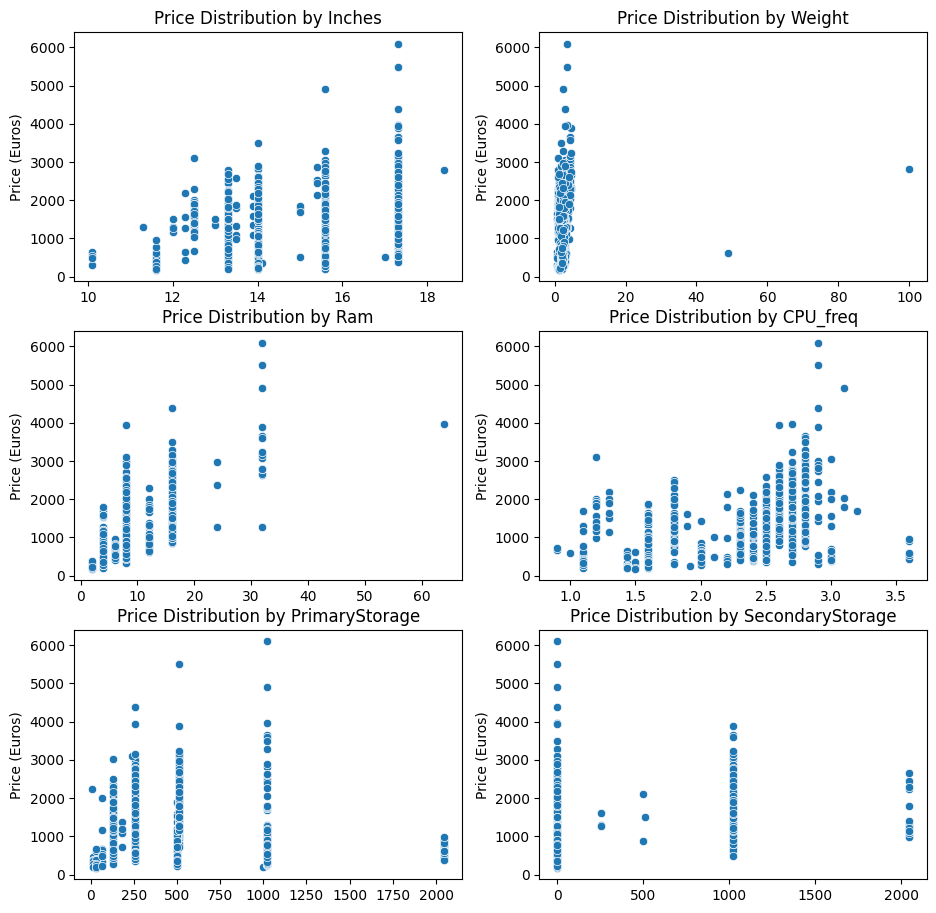

In [279]:
#Now we will look at the correlation between the numeric columns
df_laptops_numeric = df_laptops.select_dtypes(include='number')

#Plot each numeric column against the price
plt.rcParams["figure.figsize"] = [11.0, 11.0]
f, axs = plt.subplots(3, 2)

sns.scatterplot(data=df_laptops_numeric, x='Inches', y='Price_euros', ax=axs[0, 0])
sns.scatterplot(data=df_laptops_numeric, x='Weight', y='Price_euros', ax=axs[0, 1])
sns.scatterplot(data=df_laptops_numeric, x='Ram', y='Price_euros', ax=axs[1, 0])
sns.scatterplot(data=df_laptops_numeric, x='CPU_freq', y='Price_euros', ax=axs[1, 1])
sns.scatterplot(data=df_laptops_numeric, x='PrimaryStorage', y='Price_euros', ax=axs[2, 0])
sns.scatterplot(data=df_laptops_numeric, x='SecondaryStorage', y='Price_euros', ax=axs[2, 1])

for i in range(3):
    for j in range(2):
        axs[i, j].set_title('Price Distribution by ' + axs[i, j].get_xlabel())
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('Price (Euros)')

A couple of things become clear when looking at the data this way. First, the weight graph distribution is thrown off by the outliers, notably weight and RAM. Dealing with those then replotting for those two features we get the following updated plots.

(1267, 24)


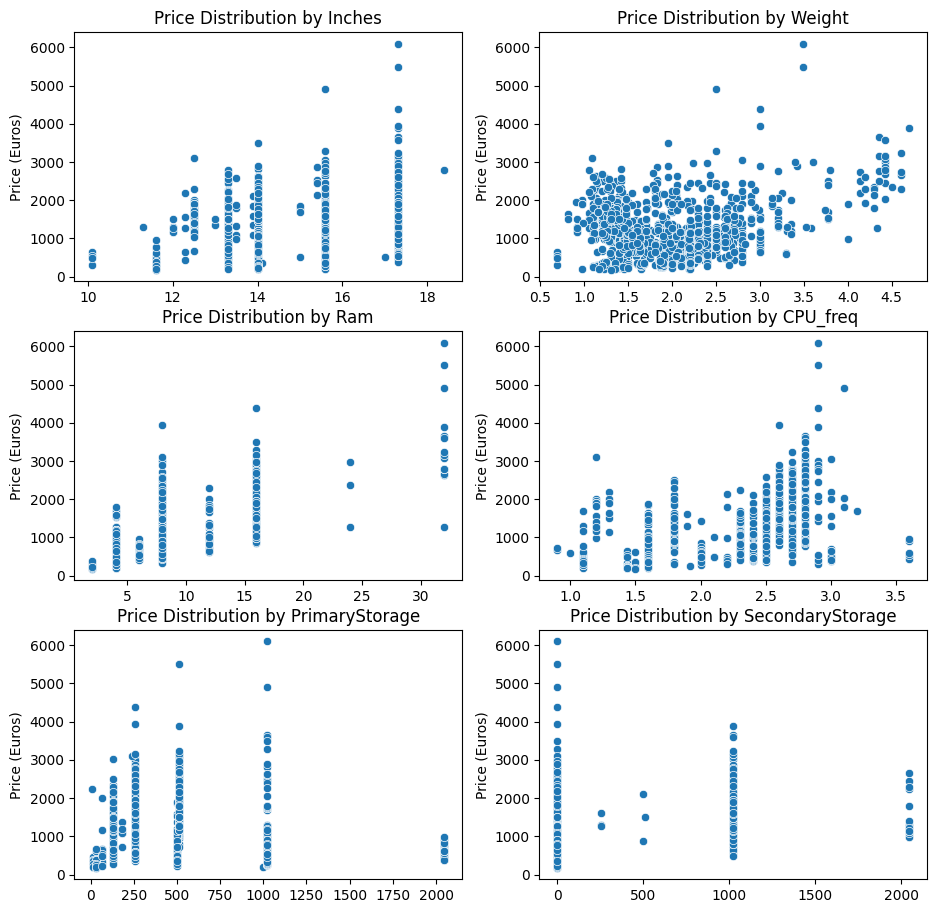

In [280]:
#Remove outliers for RAM and Weight using Z-score
df_laptops['RAM_zscore'] = abs(stats.zscore(df_laptops['Ram']))
df_laptops['Weight_zscore'] = abs(stats.zscore(df_laptops['Weight']))

#The ouliers are fairly far out, so we will remove any rows with a Z-score greater than 5
df_laptops = df_laptops[df_laptops['RAM_zscore'] < 5]
df_laptops = df_laptops[df_laptops['Weight_zscore'] < 5]

#drop the zscore columns
df_laptops.drop(columns=['RAM_zscore', 'Weight_zscore'], inplace=True)

print(df_laptops.shape)


#Plot each numeric column against the price
plt.rcParams["figure.figsize"] = [11.0, 11.0]
f, axs = plt.subplots(3, 2)

sns.scatterplot(data=df_laptops, x='Inches', y='Price_euros', ax=axs[0, 0])
sns.scatterplot(data=df_laptops, x='Weight', y='Price_euros', ax=axs[0, 1])
sns.scatterplot(data=df_laptops, x='Ram', y='Price_euros', ax=axs[1, 0])
sns.scatterplot(data=df_laptops, x='CPU_freq', y='Price_euros', ax=axs[1, 1])
sns.scatterplot(data=df_laptops, x='PrimaryStorage', y='Price_euros', ax=axs[2, 0])
sns.scatterplot(data=df_laptops, x='SecondaryStorage', y='Price_euros', ax=axs[2, 1])

for i in range(3):
    for j in range(2):
        axs[i, j].set_title('Price Distribution by ' + axs[i, j].get_xlabel())
        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('Price (Euros)')


### Final Data Setup and Modeling

#### Data Finalization

Split out the data into 3 distinct Dataframes, one for numeric only, one for categories, and one for full data. This way we can scale the numeric data independently as well as use it for linear regression.

In [281]:
print("Before shape:", df_laptops.shape)

#Drop the CPU and GPU model columns which we have adjusted
df_laptops_category_data = df_laptops.drop(columns=['CPU_model', 'GPU_model'])

print("After dropping CPU and GPU model columns shape:", df_laptops_category_data.shape)

#Drop the numeric columns
df_laptops_category_data.drop(df_laptops.select_dtypes(include='number').columns, axis=1, inplace=True)

print("After dropping numeric columns shape:", df_laptops_category_data.shape)

#Create a new dataframe with the non-numeric columns one-hot encoded
df_laptops_category_data = pd.get_dummies(df_laptops_category_data, dtype='float32')

print("One Hot Encoded + Categories shape:", df_laptops_category_data.shape)

#Create the numeric only Dataframe
df_laptops_numeric_data = df_laptops.select_dtypes(include='number')

#print the numeric shape
print("Before Numeric shape:", df_laptops_numeric_data.shape)

#We don't want to scale the price
df_laptops_numeric_data.drop(columns=['Price_euros'], inplace=True)

print("After dropping Price shape:", df_laptops_numeric_data.shape)

#Scale the numeric data
df_laptops_numeric_scaled = StandardScaler().fit_transform(df_laptops_numeric_data)

#Create a new dataframe with the scaled numeric data, keeping the index so we can merge later
df_laptops_numeric_scaled = pd.DataFrame(df_laptops_numeric_scaled, 
                                         index = df_laptops_numeric_data.index, 
                                         columns = df_laptops_numeric_data.columns)

#merge the scaled numeric data with the one-hot encoded data
df_laptops_full_data = pd.merge(df_laptops_category_data, df_laptops_numeric_scaled, left_index=True, right_index=True)

print("After shape:", df_laptops_full_data.shape)

#stringify the column names
# df_laptops_full_data.columns = [str(col) for col in df_laptops_full_data.columns]

#Add the price column back to the dataframes
df_laptops_full_data['Price_euros'] = df_laptops['Price_euros']
df_laptop_category_data['Price_euros'] = df_laptops_full_data['Price_euros']
df_laptops_numeric_scaled['Price_euros'] = df_laptops_full_data['Price_euros']




Before shape: (1267, 24)
After dropping CPU and GPU model columns shape: (1267, 22)
After dropping numeric columns shape: (1267, 13)
One Hot Encoded + Categories shape: (1267, 91)
Before Numeric shape: (1267, 9)
After dropping Price shape: (1267, 8)
After shape: (1267, 99)


### Linear Regression

Intercept:  1136.393607366716
Coefficients:  [-82.9061374  404.98024855  39.25079014 -13.7983402  188.17227039
 138.18927331 -78.17559114 -28.58859598]
MSE:  144957.26429688392
R^2:  0.674600024903879


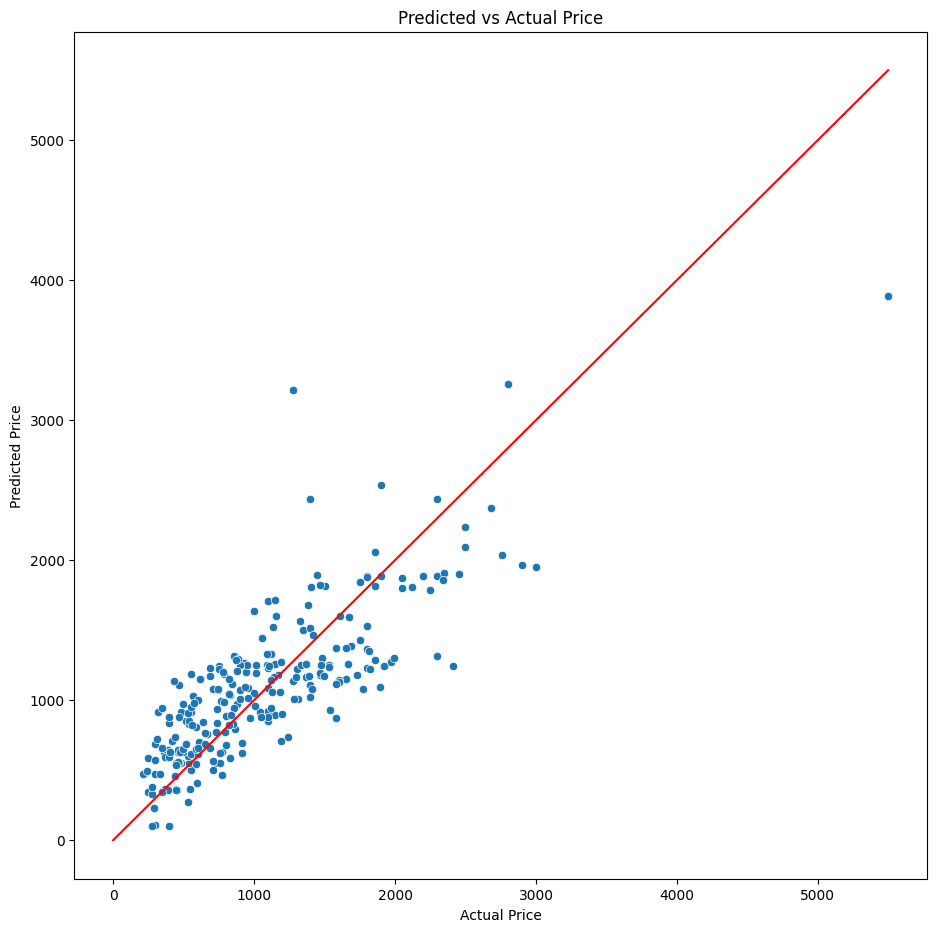

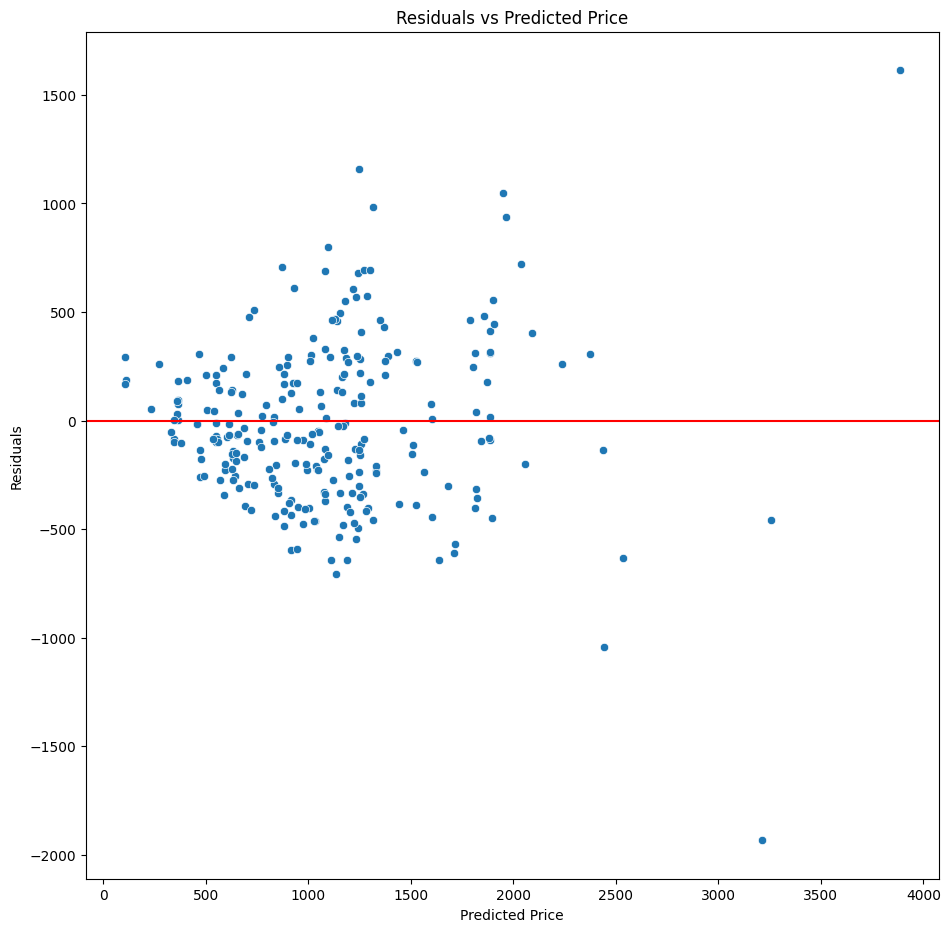

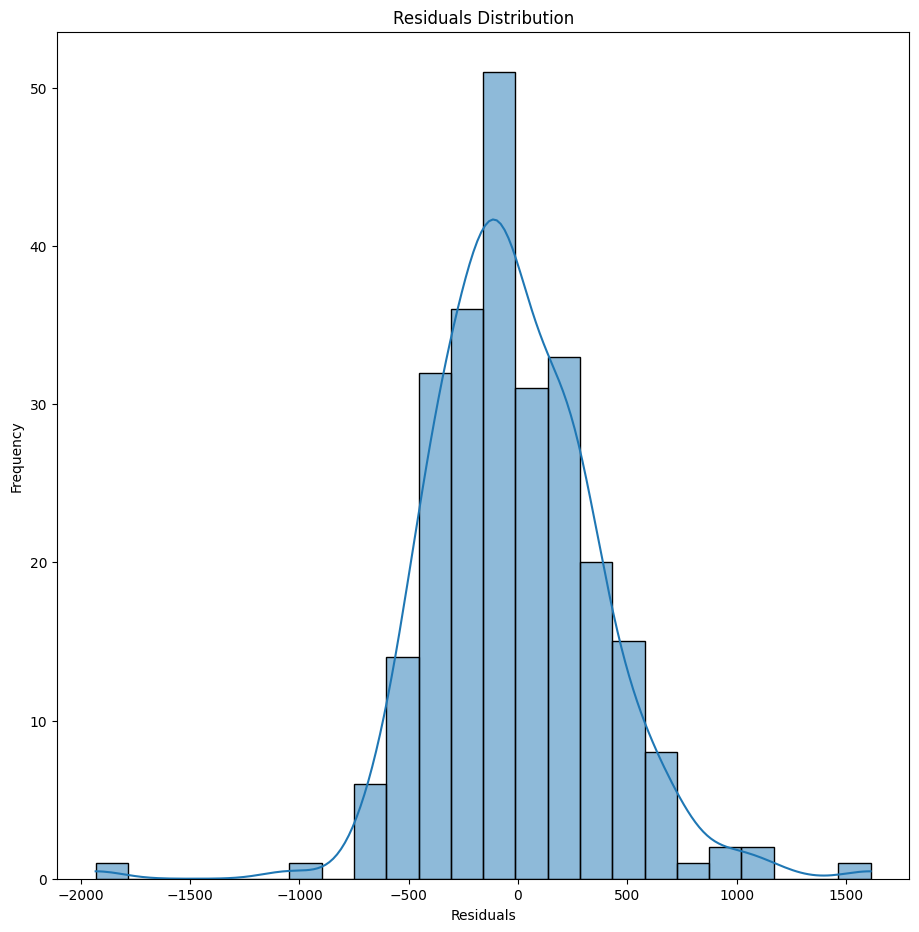

In [282]:
#Create train and test sets
X_train, X_test, Y_train, Y_test = get_train_test_data(df_laptops_numeric_scaled, 'Price_euros')

#Create our model
laptop_linear_model = LinearRegression()
laptop_linear_model.fit(X_train, Y_train)

#Get the coefficients
coefficients = laptop_linear_model.coef_

#Get the intercept
intercept = laptop_linear_model.intercept_

#Validate the model with the test set
Y_pred = laptop_linear_model.predict(X_test)

print('Intercept: ', intercept)
print('Coefficients: ', coefficients)
#Get the MSE and R squared
mse = mean_squared_error(Y_test, Y_pred)
rsqr = laptop_linear_model.score(X_test, Y_test)

print('MSE: ', mse)
print('R^2: ', rsqr)

#Plot the predicted vs actual values
sns.scatterplot(x=Y_test, y=Y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

#Add a line for the perfect model
plt.plot([0, max(Y_test)], [0, max(Y_test)], color='red')
plt.show()

#Plot the residuals
residuals = Y_test - Y_pred
sns.scatterplot(x=Y_pred, y=residuals)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

#Plot the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

#### Dealing with the Heteroskedasticity of the residuals

The graph of the residuals shows that as price increases the error increases. Ideally we'd like to eliminate this if possible. Can use the sklearn PowerTransformer to adjust for this to attempt to make the overall data more Guassian.

Intercept:  1136.3168576505186
Coefficients:  [-17.0019809  371.22433539 -33.81495837  71.2035926   91.21929321
 116.9427279  -16.95563914  17.57390013]
MSE:  176776.15234001144
R^2:  0.6031730051747096


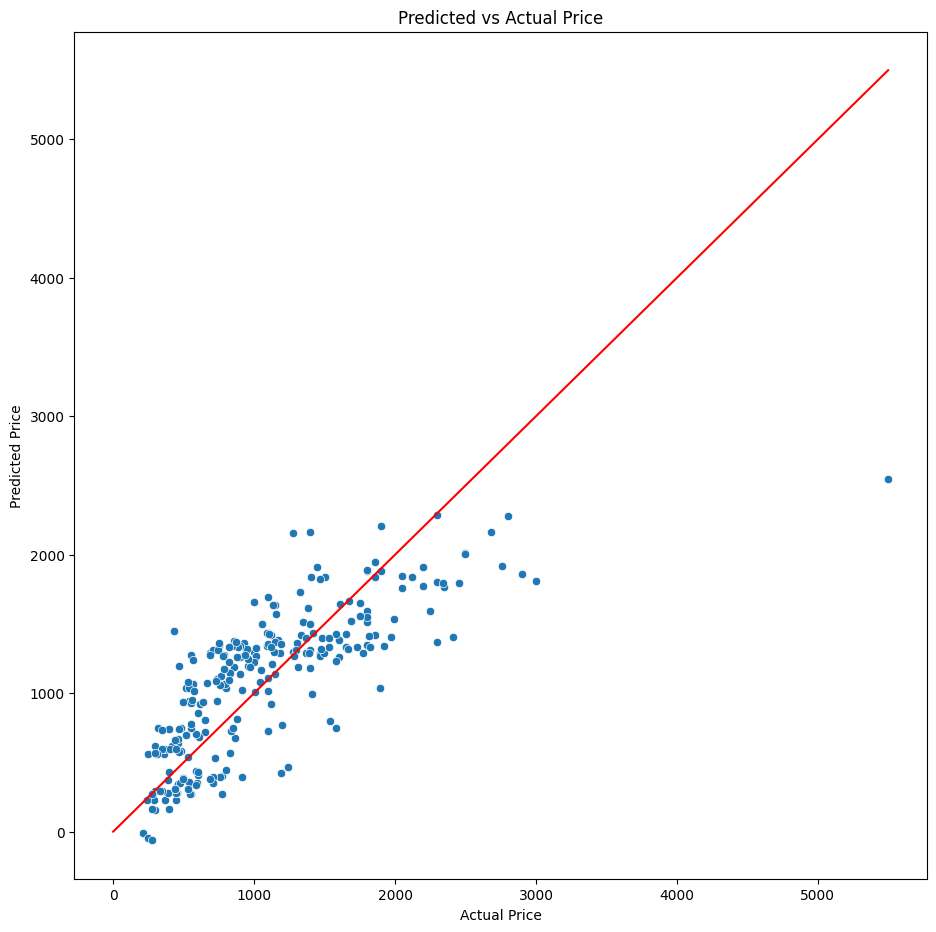

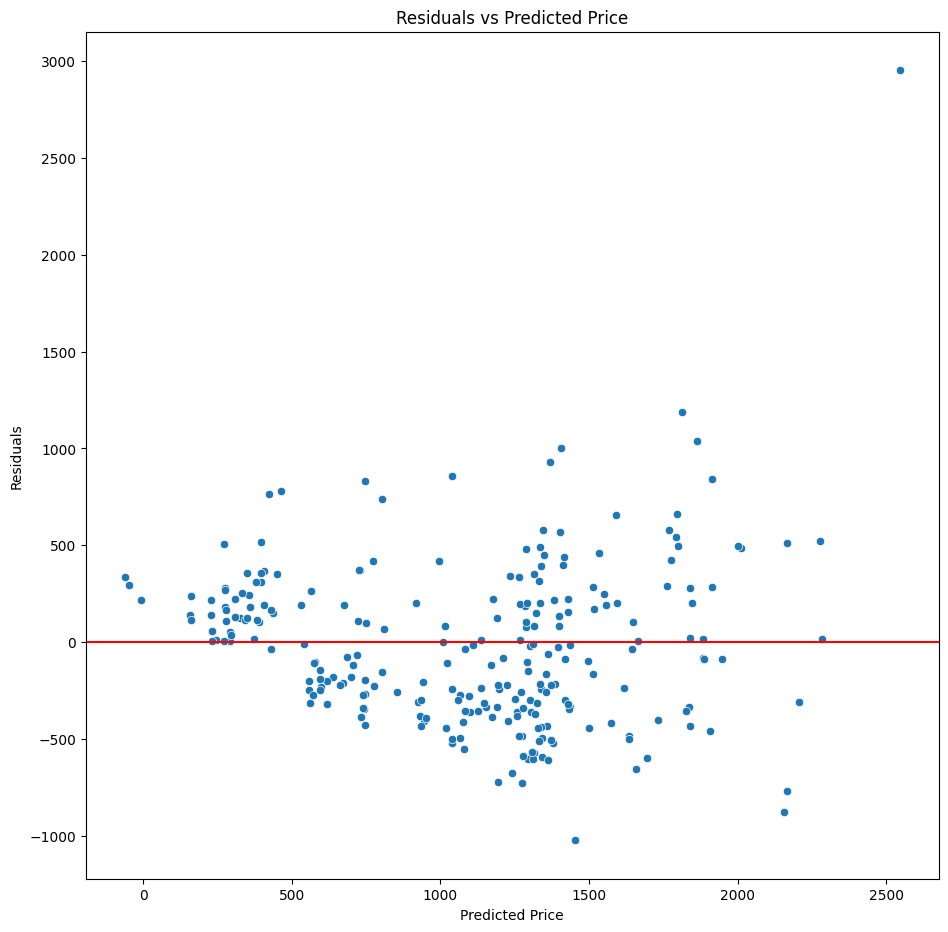

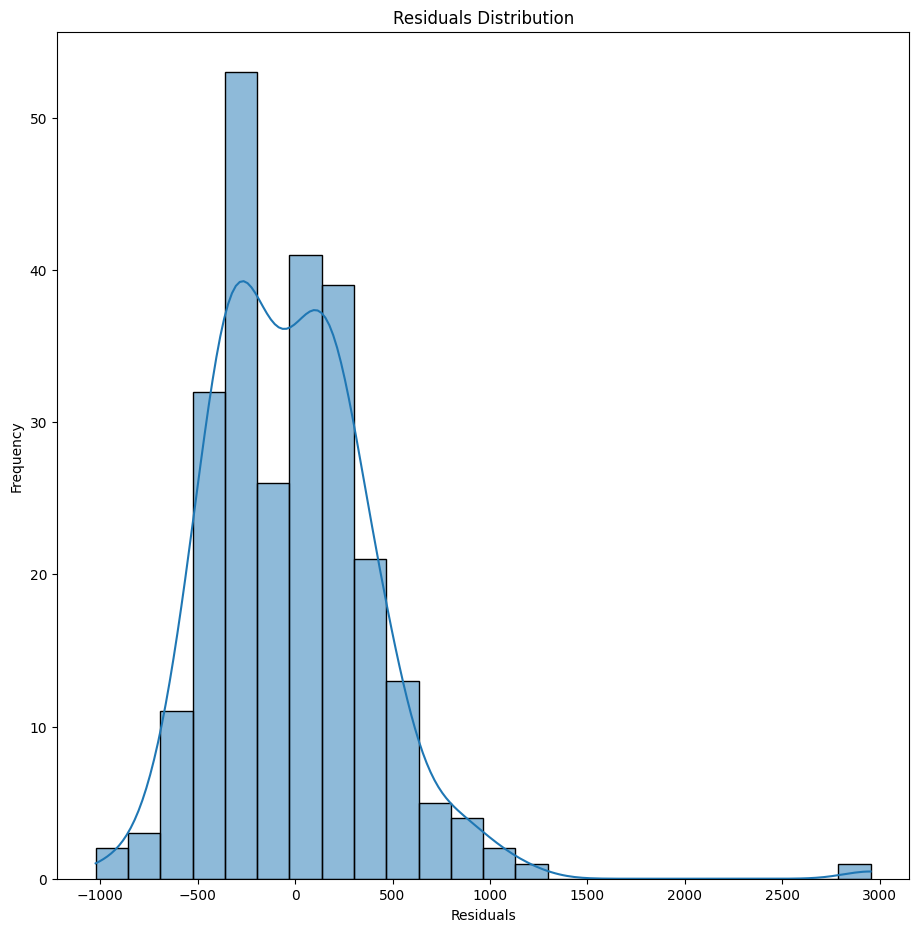

In [283]:
from sklearn.preprocessing import PowerTransformer

#Create our X and Y data
#Only use the numeric columns
X = df_laptops_numeric_scaled.drop(columns=['Price_euros'])
Y = df_laptops_numeric_scaled['Price_euros']

X = PowerTransformer().fit_transform(X)

#Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Create our model
laptop_linear_model = LinearRegression()
laptop_linear_model.fit(X_train, Y_train)

#Get the coefficients
coefficients = laptop_linear_model.coef_

#Get the intercept
intercept = laptop_linear_model.intercept_

#Validate the model with the test set
Y_pred = laptop_linear_model.predict(X_test)

print('Intercept: ', intercept)
print('Coefficients: ', coefficients)
#Get the MSE and R squared
mse = mean_squared_error(Y_test, Y_pred)
rsqr = laptop_linear_model.score(X_test, Y_test)

print('MSE: ', mse)
print('R^2: ', rsqr)

#Plot the predicted vs actual values
sns.scatterplot(x=Y_test, y=Y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

#Add a line for the perfect model
plt.plot([0, max(Y_test)], [0, max(Y_test)], color='red')
plt.show()

#Plot the residuals
residuals = Y_test - Y_pred
sns.scatterplot(x=Y_pred, y=residuals)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

#Plot the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

The accuracy of the model has gone down. We could explore further transforms such as spline or poly but for purposes of this project we'll move onto futher models.

### Decision Tree

MSE:  73075.10088730349
R^2:  0.8359610598046707


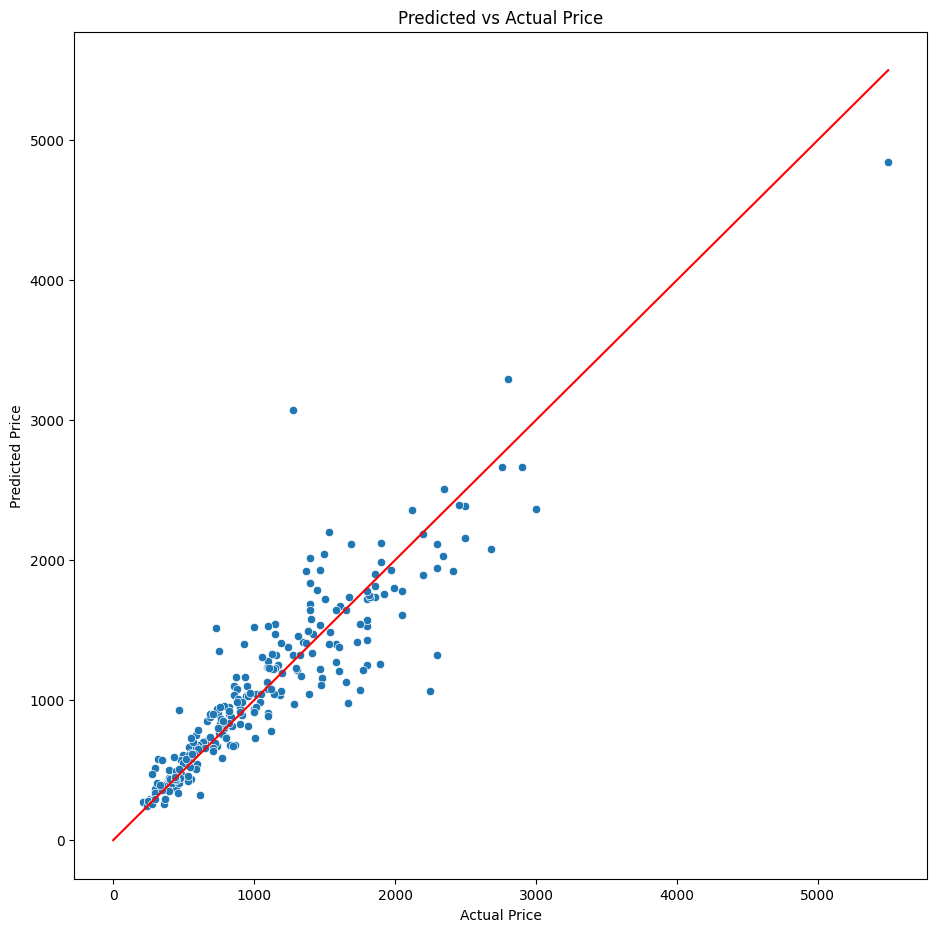

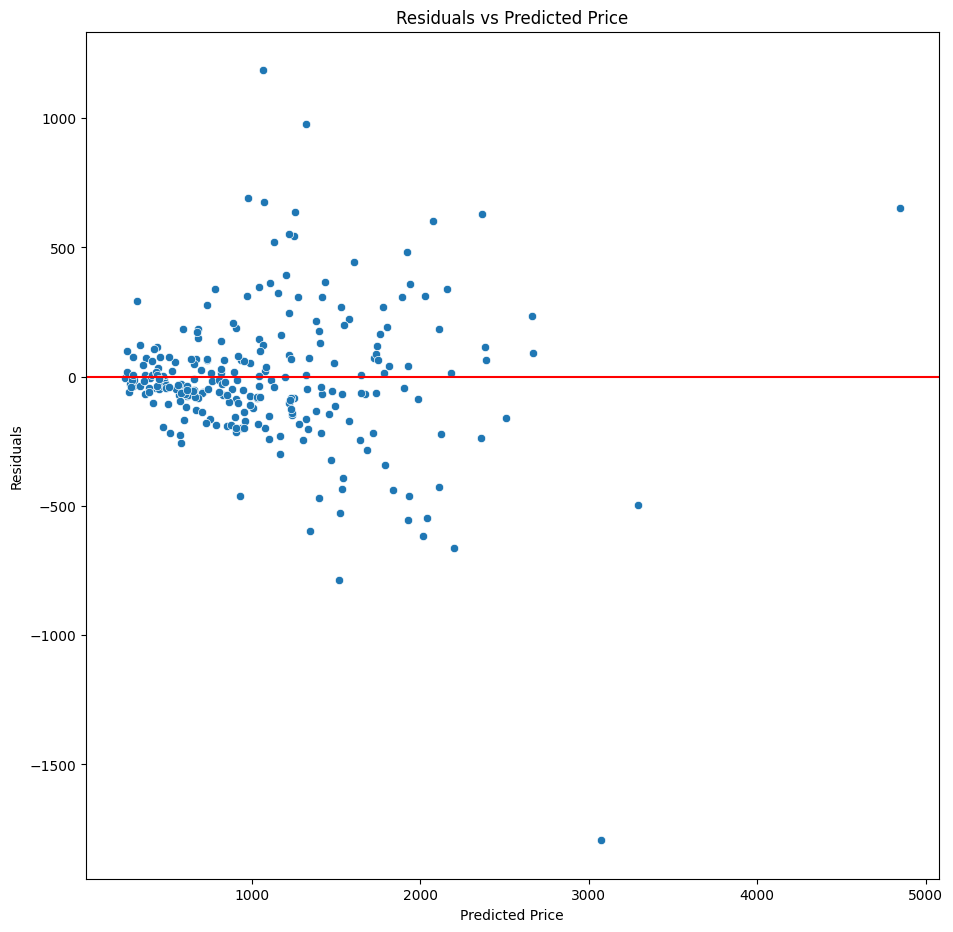

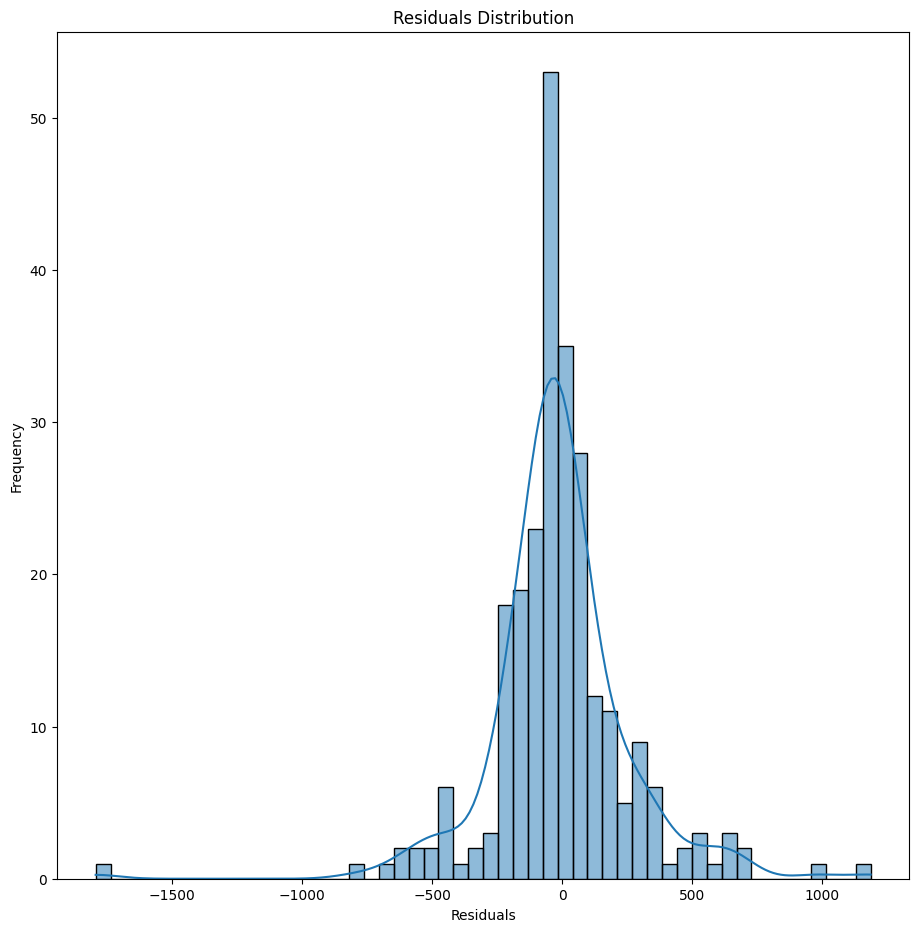

In [284]:
#Create X and Y
X = df_laptops_full_data.drop(columns=['Price_euros'])
Y = df_laptops_full_data['Price_euros']

#Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

laptop_rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
laptop_rf_model.fit(X_train, Y_train)

#Validate the model with the test set
Y_pred = laptop_rf_model.predict(X_test)

#Get the MSE and R squared
mse = mean_squared_error(Y_test, Y_pred)
rsqr = laptop_rf_model.score(X_test, Y_test)

print('MSE: ', mse)
print('R^2: ', rsqr)

#Plot the predicted vs actual values
sns.scatterplot(x=Y_test, y=Y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

#Add a line for the perfect model
plt.plot([0, max(Y_test)], [0, max(Y_test)], color='red')
plt.show()

#Plot the residuals
residuals = Y_test - Y_pred
sns.scatterplot(x=Y_pred, y=residuals)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

#Plot the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

### Modeling - Neural Network

Best MSE:  71075.37440239295
Best Hidden Layer Size:  70
MSE:  71075.37440239295
R^2:  0.8404500445516251


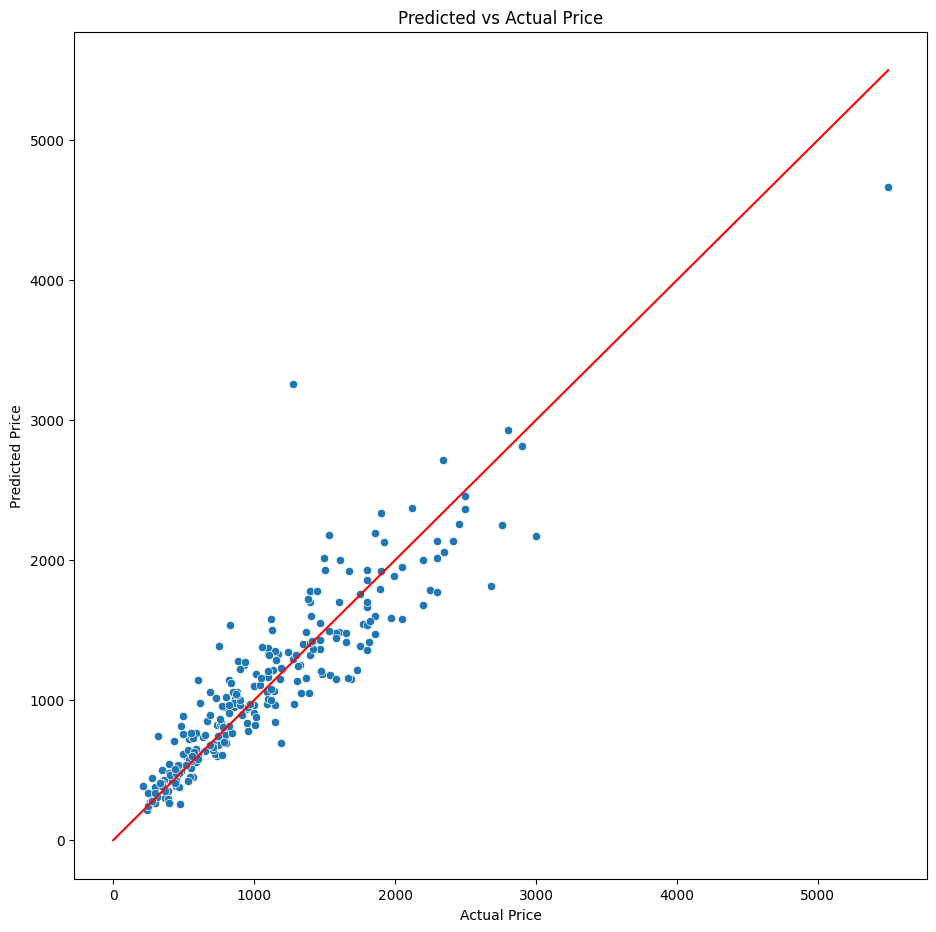

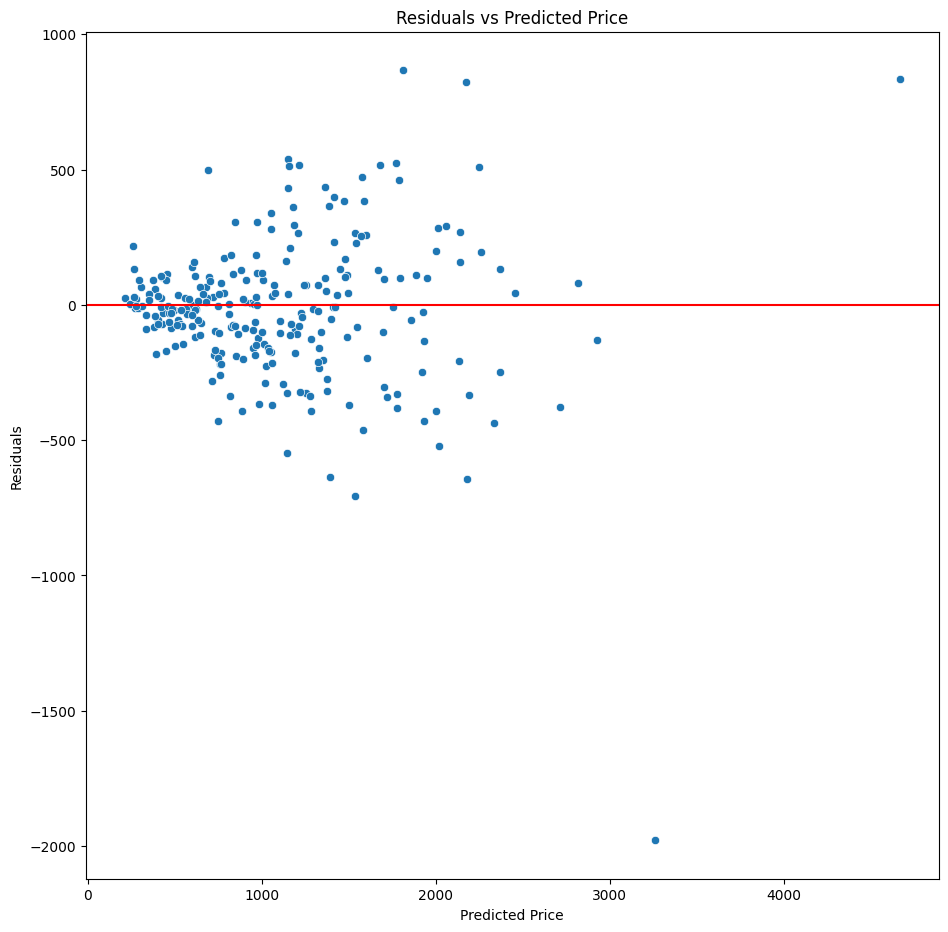

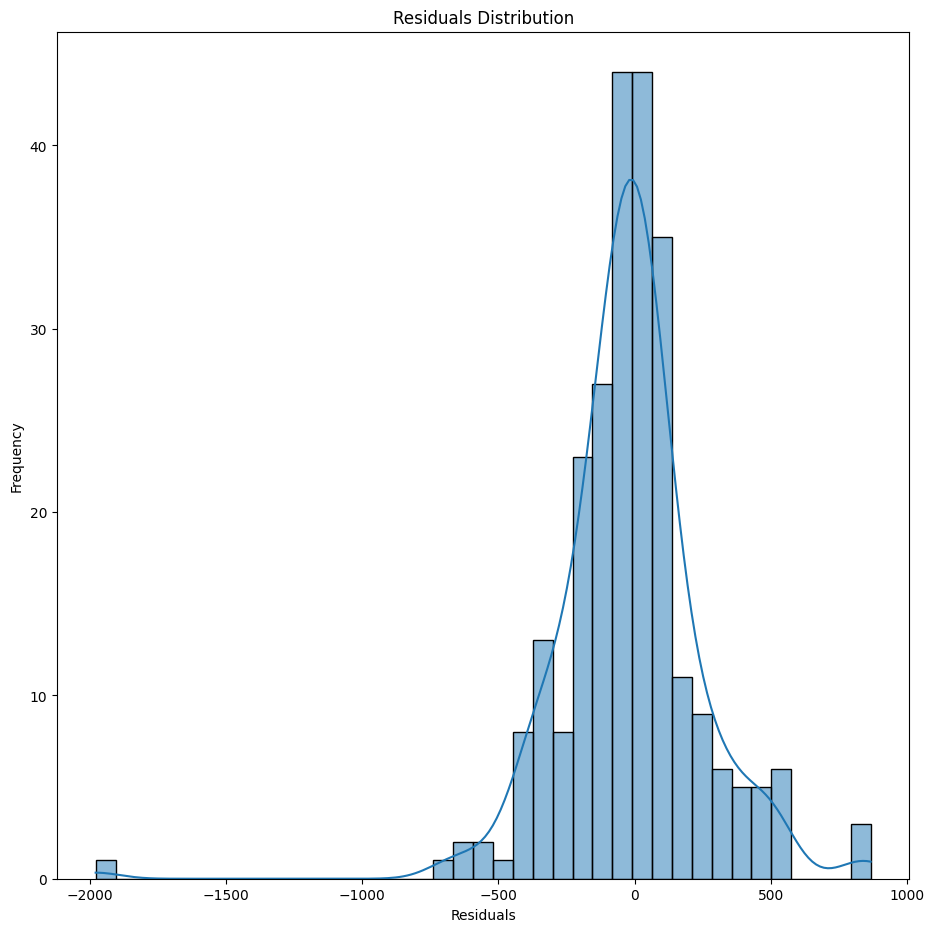

In [285]:
#Create X and Y
X = df_laptops_full_data.drop(columns=['Price_euros'])
Y = df_laptops_full_data['Price_euros']

#Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

best_mse = math.inf
best_size = 0
#loop through different hidden layer sizes
for i in range(10, 100, 10):
    laptop_mlp_model = MLPRegressor(hidden_layer_sizes=(i,i,i), max_iter=10000, random_state=42, early_stopping=True)
    laptop_mlp_model.fit(X_train, Y_train)
    Y_pred = laptop_mlp_model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    
    if mse < best_mse:
        best_mse = mse
        best_size = i
        
print('Best MSE: ', best_mse)
print('Best Hidden Layer Size: ', best_size)


laptop_mlp_model = MLPRegressor(hidden_layer_sizes=(best_size,best_size,best_size), max_iter=10000, random_state=42, early_stopping=True)

laptop_mlp_model.fit(X_train, Y_train)

#Validate the model with the test set
Y_pred = laptop_mlp_model.predict(X_test)

#Get the MSE and R squared
mse = mean_squared_error(Y_test, Y_pred)
rsqr = laptop_mlp_model.score(X_test, Y_test)

print('MSE: ', mse)
print('R^2: ', rsqr)

#Plot the predicted vs actual values
sns.scatterplot(x=Y_test, y=Y_pred)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual Price')

#Add a line for the perfect model
plt.plot([0, max(Y_test)], [0, max(Y_test)], color='red')
plt.show()

#Plot the residuals
residuals = Y_test - Y_pred
sns.scatterplot(x=Y_pred, y=residuals)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Price')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

#Plot the residuals
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()


## Task 2 - Classification of Student Success

### Dataload
Load the csv

In [286]:

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/student_dropout_academic_success.csv'
s = requests.get(url).content
df_student = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_student.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5.0,171.0,1.0,1.0,122.0,1.0,19.0,12.0,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1.0,9254.0,1.0,1.0,160.0,1.0,1.0,3.0,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5.0,9070.0,1.0,1.0,122.0,1.0,37.0,37.0,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2.0,9773.0,1.0,1.0,122.0,1.0,38.0,37.0,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1.0,8014.0,0.0,1.0,100.0,1.0,37.0,38.0,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Data Cleaning

In [287]:
#Get the different column types
print(df_student.info())

#Check for missing values
print(df_student.isna().sum())

#Remove rows with missing values
df_student.dropna(inplace=True)

#Check for missing values
print(df_student.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4423 non-null   float64
 3   Course                                          4422 non-null   float64
 4   Daytime/evening attendance	                     4421 non-null   float64
 5   Previous qualification                          4421 non-null   float64
 6   Previous qualification (grade)                  4419 non-null   float64
 7   Nacionality                                     4419 non-null   float64
 8   Mother's qualification                          4420 non-null   float64
 9   Father's qualification                   

### Data Exploration

First we'll take a look at unique values as well.

In [288]:
#print the unique values for each column
print(df_student.nunique())

Marital status                                      6
Application mode                                   18
Application order                                   8
Course                                             17
Daytime/evening attendance\t                        2
Previous qualification                             17
Previous qualification (grade)                    101
Nacionality                                        21
Mother's qualification                             29
Father's qualification                             34
Mother's occupation                                33
Father's occupation                                46
Admission grade                                   618
Displaced                                           2
Educational special needs                           3
Debtor                                              2
Tuition fees up to date                             2
Gender                                              2
Scholarship holder          

Does GDP, Unemployment rate, or Inflation rate have anything to do with predicting success?

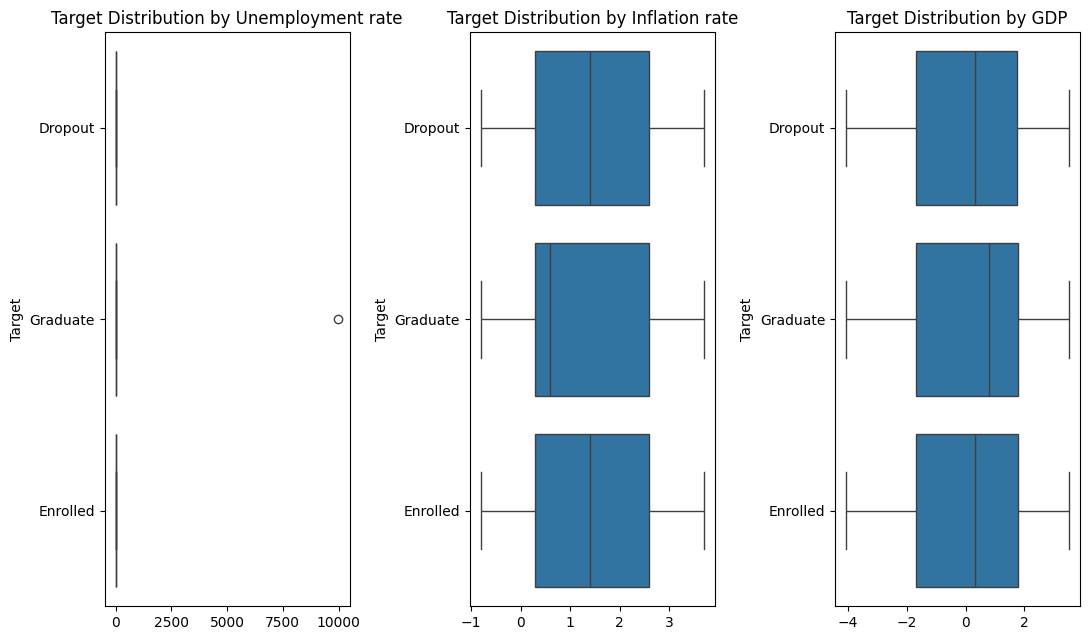

In [289]:
#plot the Target against Unemployment rate, Inflation rate and GDP
plt.rcParams["figure.figsize"] = [11.0, 6.50]
f, axs = plt.subplots(1, 3)

sns.boxplot(data=df_student, x='Unemployment rate', y='Target', ax=axs[0])
sns.boxplot(data=df_student, x='Inflation rate', y='Target', ax=axs[1])
sns.boxplot(data=df_student, x='GDP', y='Target', ax=axs[2])

for i in range(3):
    axs[i].set_title('Target Distribution by ' + axs[i].get_xlabel())
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Target')
plt.tight_layout()
plt.show()

There is an obvious outlier for Unemployment rate, let's clear that out and replot.

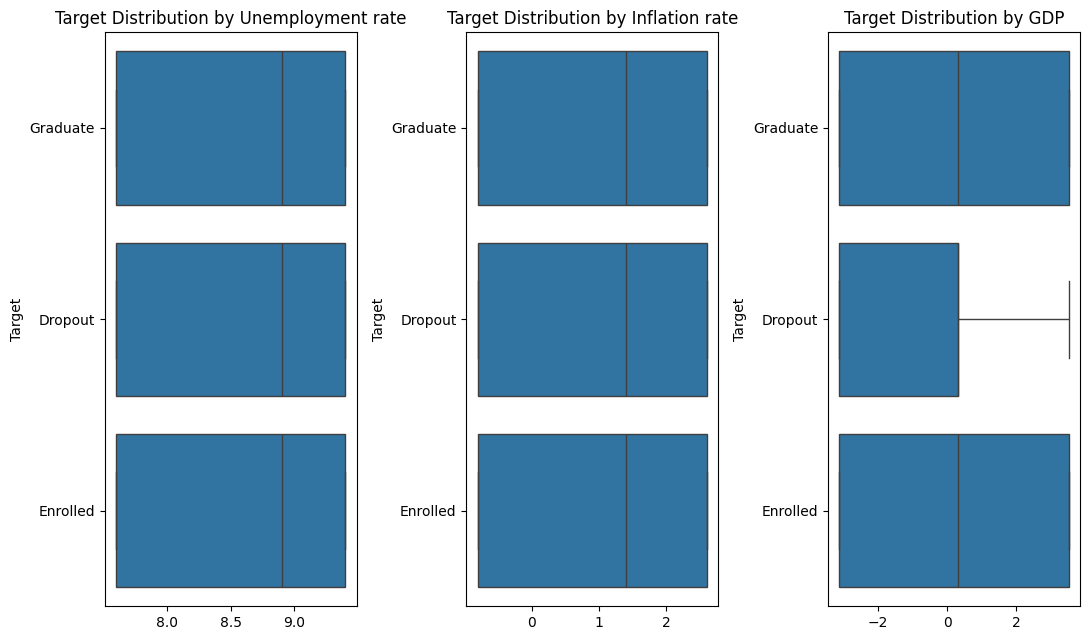

In [290]:
#Remove rows from df_student where Unemployment rate < 10
df_student = df_student[df_student['Unemployment rate']<10]

#Replot
plt.rcParams["figure.figsize"] = [11.0, 6.50]
f, axs = plt.subplots(1, 3)

sns.boxplot(data=df_student, x='Unemployment rate', y='Target', ax=axs[0])
sns.boxplot(data=df_student, x='Inflation rate', y='Target', ax=axs[1])
sns.boxplot(data=df_student, x='GDP', y='Target', ax=axs[2])

for i in range(3):
    axs[i].set_title('Target Distribution by ' + axs[i].get_xlabel())
    axs[i].set_xlabel('')
    axs[i].set_ylabel('Target')
plt.tight_layout()
plt.show()

Now that we look at this data it becomes a bit more obvious that these feature are unrelated as predictors, so we can drop them.

In [291]:
#Drop Unemployment rate, Inflation rate, and GDP
df_student = df_student.drop(columns=['Unemployment rate', 'Inflation rate', 'GDP'])

### Modeling

Accuracy:  0.9141630901287554
Confusion Matrix:
 [[ 85  12]
 [  8 128]]
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.91      0.88      0.89        97
    Graduate       0.91      0.94      0.93       136

    accuracy                           0.91       233
   macro avg       0.91      0.91      0.91       233
weighted avg       0.91      0.91      0.91       233

Accuracy:  0.9012875536480687
Confusion Matrix:
 [[ 78  19]
 [  4 132]]
Classification Report:
               precision    recall  f1-score   support

     Dropout       0.95      0.80      0.87        97
    Graduate       0.87      0.97      0.92       136

    accuracy                           0.90       233
   macro avg       0.91      0.89      0.90       233
weighted avg       0.91      0.90      0.90       233



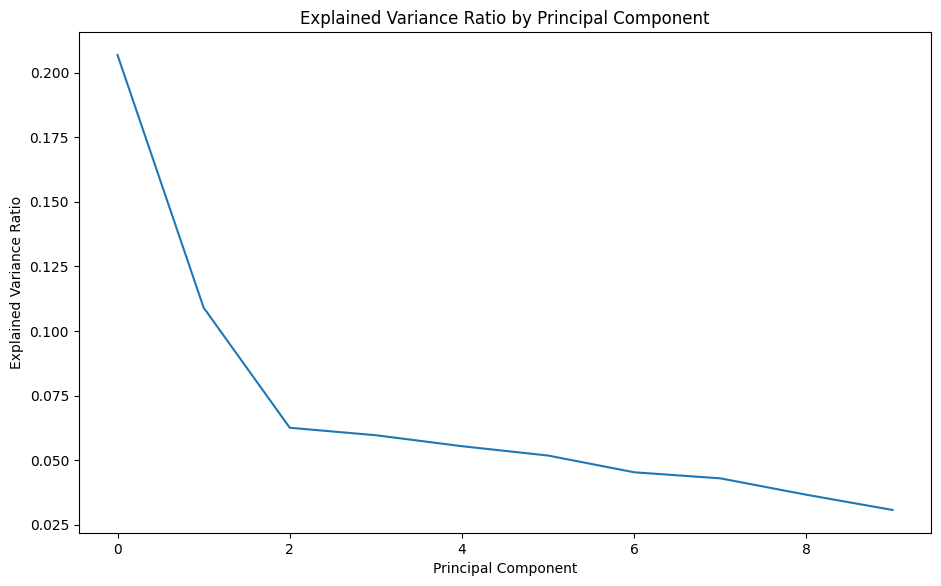

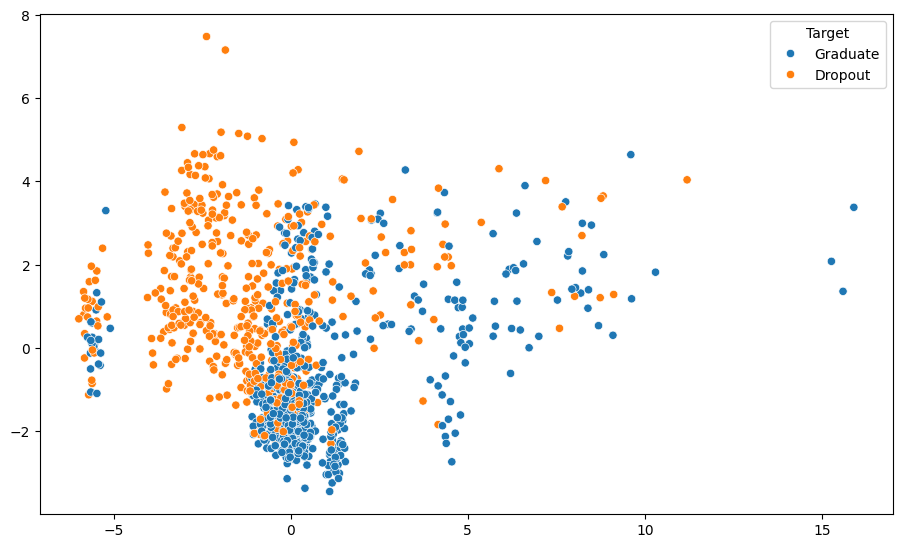

In [292]:
#drop all rows where Target is Enrolled
df_student_pass_fail = df_student[df_student['Target'] != 'Enrolled']

X = df_student_pass_fail.drop(columns=['Target'])
Y = df_student_pass_fail['Target']

#scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

#Create train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#Logistic Regression
student_logistic_model = LogisticRegression()
student_logistic_model.fit(X_train, Y_train)

#Validate the model with the test set
Y_pred = student_logistic_model.predict(X_test)

#Get the accuracy
accuracy = student_logistic_model.score(X_test, Y_test)

print('Accuracy: ', accuracy)

#Get the confusion matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(Y_test, Y_pred)

print('Confusion Matrix:\n', conf_matrix)

#Get the classification report
from sklearn.metrics import classification_report

class_report = classification_report(Y_test, Y_pred)

print('Classification Report:\n', class_report)


#now model using SVM
from sklearn.svm import SVC

student_svm_model = SVC()
student_svm_model.fit(X_train, Y_train)

#Validate the model with the test set
Y_pred = student_svm_model.predict(X_test)

#Get the accuracy
accuracy = student_svm_model.score(X_test, Y_test)

print('Accuracy: ', accuracy)

#Get the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

print('Confusion Matrix:\n', conf_matrix)

#Get the classification report
class_report = classification_report(Y_test, Y_pred)

print('Classification Report:\n', class_report)

#Look at the PCA components
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

#plot the explained variance ratio
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.show()


#plot the success fail data against the first two PCA components

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=Y)

plt.show()





## Task 3 - Clustering of Apartments for Rent

### Dataload
Load the csv

In [293]:

# # Load your dataset
url = 'https://raw.githubusercontent.com/wortcook/UMKC/refs/heads/main/Fall2024/CS5530-0005/proj/apartments_for_rent.csv'
s = requests.get(url).content
df_apartment = pd.read_csv(io.StringIO(s.decode('utf-8')))
df_apartment.head()

,id,bathrooms,bedrooms,fee,pets_allowed,price,price_type,square_feet,state,latitude,longitude
0,5.668640e+09,1.0,1.0,No,Cats,2195.0,Monthly,542.0,CA,33.8520,-118.3759
1,5.668640e+09,1.5,3.0,No,"Cats,Dogs",1250.0,Monthly,1500.0,VA,37.0867,-76.4941
2,5.668640e+09,2.0,3.0,No,NaN,1395.0,Monthly,1650.0,NC,35.8230,-78.6438
3,5.668640e+09,1.0,2.0,No,"Cats,Dogs",1600.0,Monthly,820.0,CA,38.3622,-121.9712
4,5.668639e+09,1.0,1.0,No,"Cats,Dogs",975.0,Monthly,624.0,NM,35.1038,-106.6110


### Data Cleaning

In [294]:
df_apartment.info()
df_apartment.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99492 entries, 0 to 99491
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            99491 non-null  float64
 1   bathrooms     99427 non-null  float64
 2   bedrooms      99365 non-null  float64
 3   fee           99490 non-null  object 
 4   pets_allowed  39066 non-null  object 
 5   price         99491 non-null  float64
 6   price_type    99489 non-null  object 
 7   square_feet   99491 non-null  float64
 8   state         99189 non-null  object 
 9   latitude      99465 non-null  float64
 10  longitude     99466 non-null  float64
dtypes: float64(7), object(4)
memory usage: 8.3+ MB


id                  1
bathrooms          65
bedrooms          127
fee                 2
pets_allowed    60426
price               1
price_type          3
square_feet         1
state             303
latitude           27
longitude          26
dtype: int64

The large number of pets_allowed NaN values tells us we should not likely drop this data. Instead we will assume that a proper value is either "No" or "Not Allowed". First though, we'll see what unique values are in that column.

In [295]:
#Get the unique values for the pets_allowed column and the counts of each
df_apartment['pets_allowed'].value_counts()

pets_allowed
Cats,Dogs         37095
Cats               1843
Dogs                127
Cats,Dogs,None        1
Name: count, dtype: int64

In [296]:
#Switch nan values to "None" and let's also switch the Cats,Dogs,None to Cats,Dogs since it doesn't make sense
df_apartment['pets_allowed'].fillna('None', inplace=True)
df_apartment['pets_allowed'] = df_apartment['pets_allowed'].apply(lambda x: 'Cats,Dogs' if x in ['Cats,Dogs,None', 'Cats,None', 'Dogs,None'] else x)

#show the unique values for the pets_allowed column
print(df_apartment['pets_allowed'].value_counts())

#Now drop the rows with missing values
df_apartment.dropna(inplace=True)

print(df_apartment.isna().sum())

#We also don't need the id column
df_apartment.drop(columns=['id'], inplace=True)

pets_allowed
None         60426
Cats,Dogs    37096
Cats          1843
Dogs           127
Name: count, dtype: int64
id              0
bathrooms       0
bedrooms        0
fee             0
pets_allowed    0
price           0
price_type      0
square_feet     0
state           0
latitude        0
longitude       0
dtype: int64


In [297]:
#Show the unique values for the price_type column
print(df_apartment['price_type'].value_counts())
print(df_apartment['fee'].value_counts())



price_type
Monthly    99001
Weekly         3
Name: count, dtype: int64
fee
No     98807
Yes      197
Name: count, dtype: int64


Price type "Weekly", since there are only 3 rows, is unlikely to contribute to any meaningful analysis so we'll drop the column as that would only leave a single category of data.

In [298]:
#Drop price_type column
df_apartment.drop(columns=['price_type'], inplace=True)

### Data Exploration

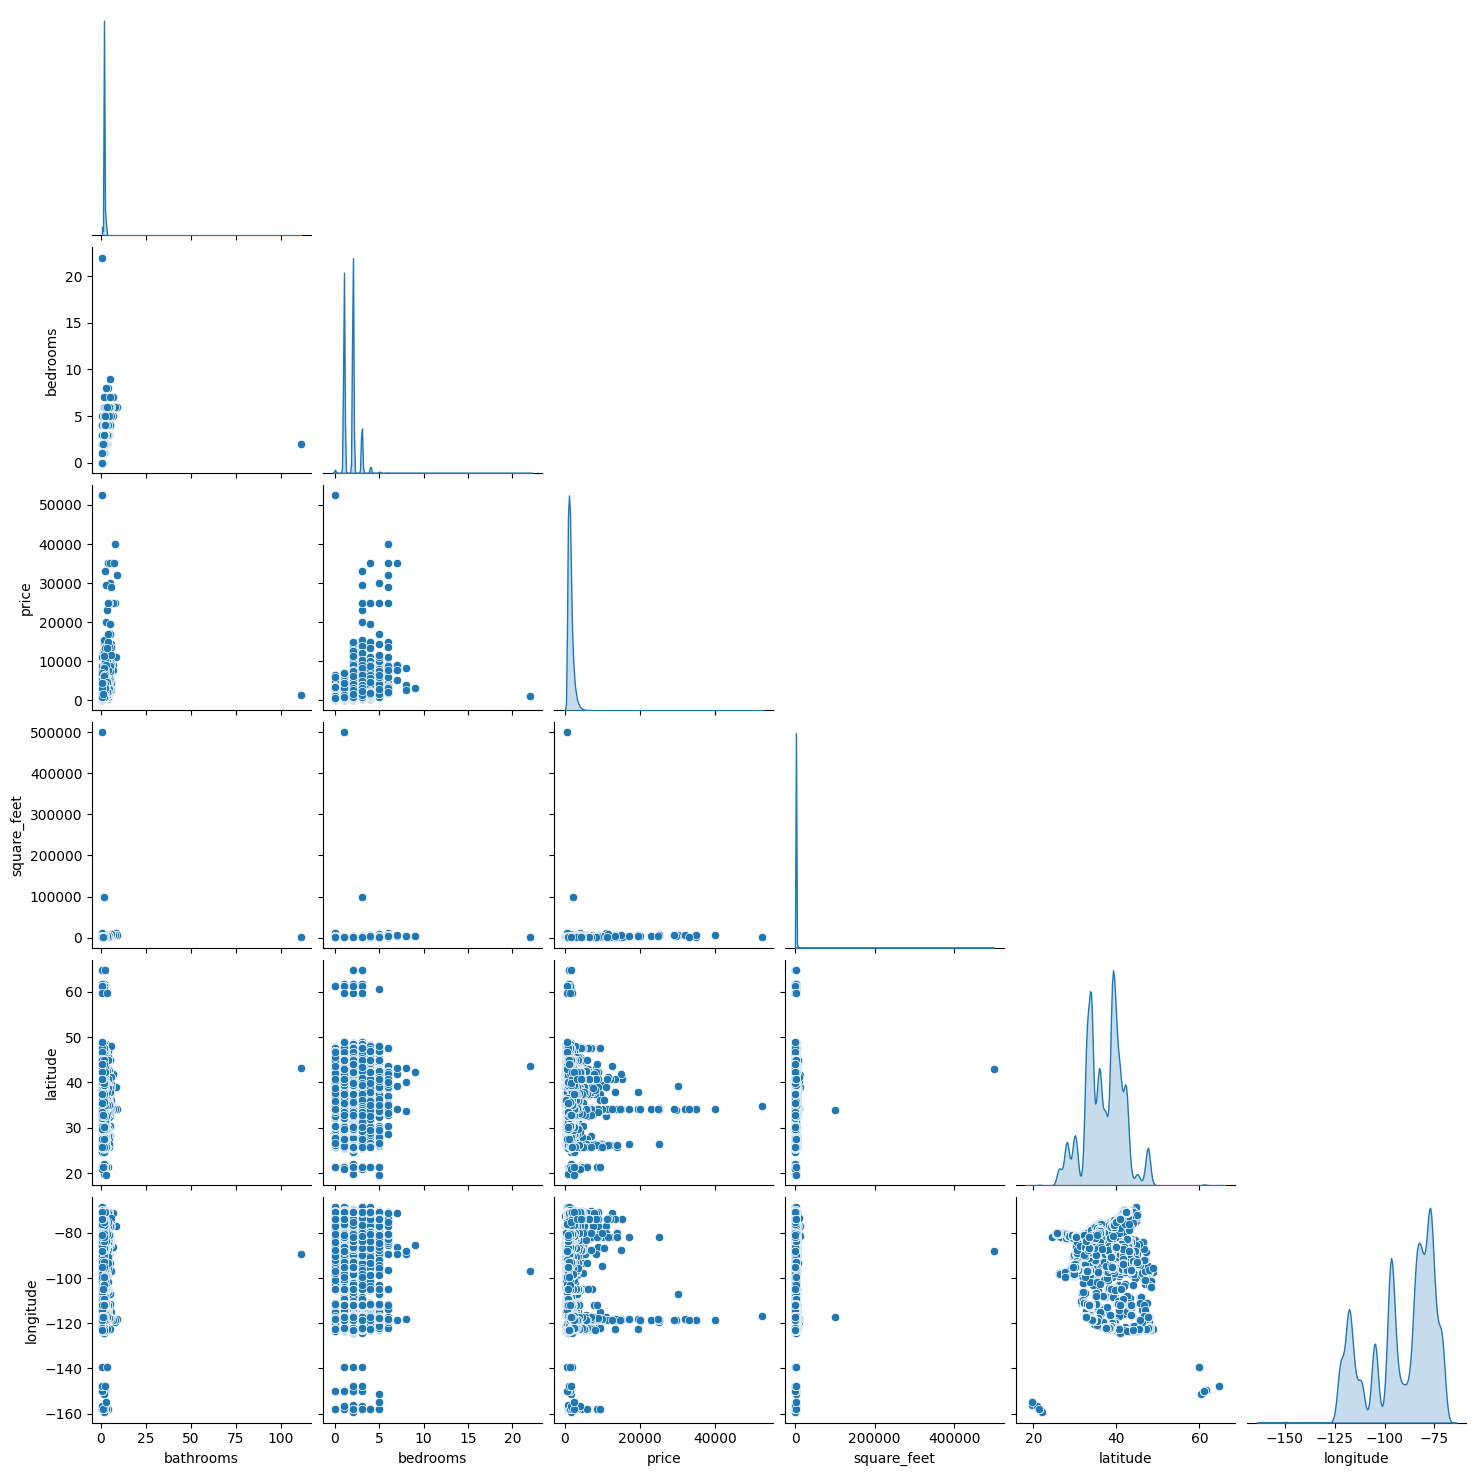

In [299]:
#Show a pairplot of the numeric columns
sns.pairplot(df_apartment.select_dtypes(include='number'), diag_kind='kde', corner=True)

If we look carefully at the latitude vs. longitude data it is (as we would expect after some thought) a map of the United States, including outliers for Alaska and Hawaii. The state and lat/long columns are highly correlated so we can pick one or the other. Since the state is a category and it is possible there are regional variances that we might want modeled we'll drop the state column.

In [300]:
#Drop the state column
df_apartment.drop(columns=['state'], inplace=True)

### Data Finalization

In [301]:
#Scale the data but only the numeric columns

df_apartment_numeric = df_apartment.select_dtypes(include='number')

print(df_apartment_numeric.head())

print("*"*50)

df_apartment_scaled = StandardScaler().fit_transform(df_apartment_numeric)

df_apartment_scaled = pd.DataFrame(df_apartment_scaled, index = df_apartment_numeric.index, columns = df_apartment_numeric.columns)

#Convert the categorical columns to one-hot encoded columns
#finally convert the remaining categorical columns to one-hot encoded columns
df_apartment_categories = df_apartment.select_dtypes(include='object')

df_apartment_categories = pd.get_dummies(df_apartment_categories, dtype='float32')

#Merge the scaled numeric columns with the one-hot encoded columns
df_apartment_to_cluster = pd.merge(df_apartment_scaled, df_apartment_categories, left_index=True, right_index=True)

print(df_apartment_to_cluster.head())

   bathrooms  bedrooms   price  square_feet  latitude  longitude
0        1.0       1.0  2195.0        542.0   33.8520  -118.3759
1        1.5       3.0  1250.0       1500.0   37.0867   -76.4941
2        2.0       3.0  1395.0       1650.0   35.8230   -78.6438
3        1.0       2.0  1600.0        820.0   38.3622  -121.9712
4        1.0       1.0   975.0        624.0   35.1038  -106.6110
**************************************************
   bathrooms  bedrooms     price  square_feet  latitude  longitude  fee_No  \
0  -0.689264 -0.969988  0.744132    -0.253436 -0.671112  -1.695475     1.0   
1   0.081695  1.691487 -0.306619     0.324465  0.031541   0.950985     1.0   
2   0.852654  1.691487 -0.145393     0.414951 -0.242965   0.815148     1.0   
3  -0.689264  0.360750  0.082548    -0.085736  0.308609  -1.922658     1.0   
4  -0.689264 -0.969988 -0.612393    -0.203970 -0.399192  -0.952065     1.0   

   fee_Yes  pets_allowed_Cats  pets_allowed_Cats,Dogs  pets_allowed_Dogs  \
0      0.0    

### Modeling

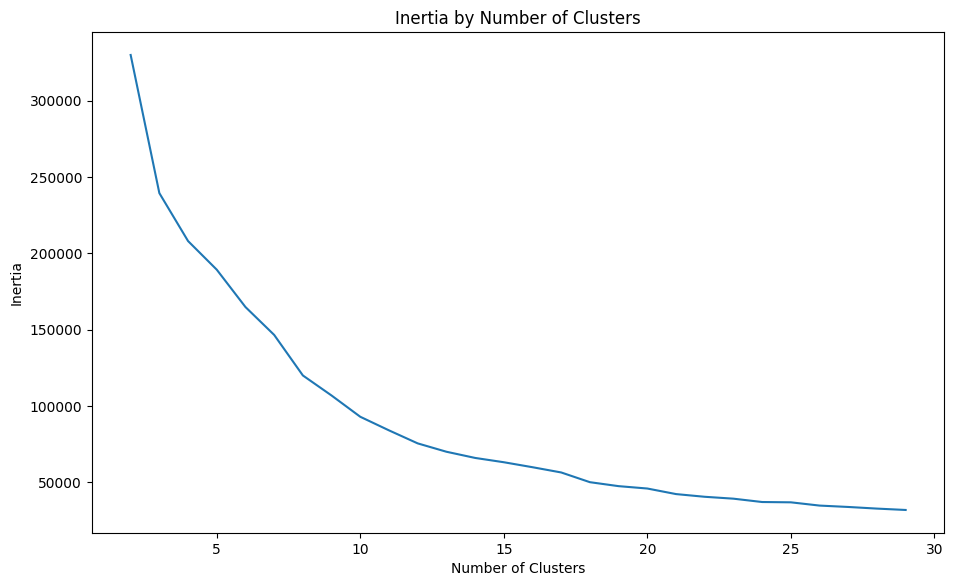

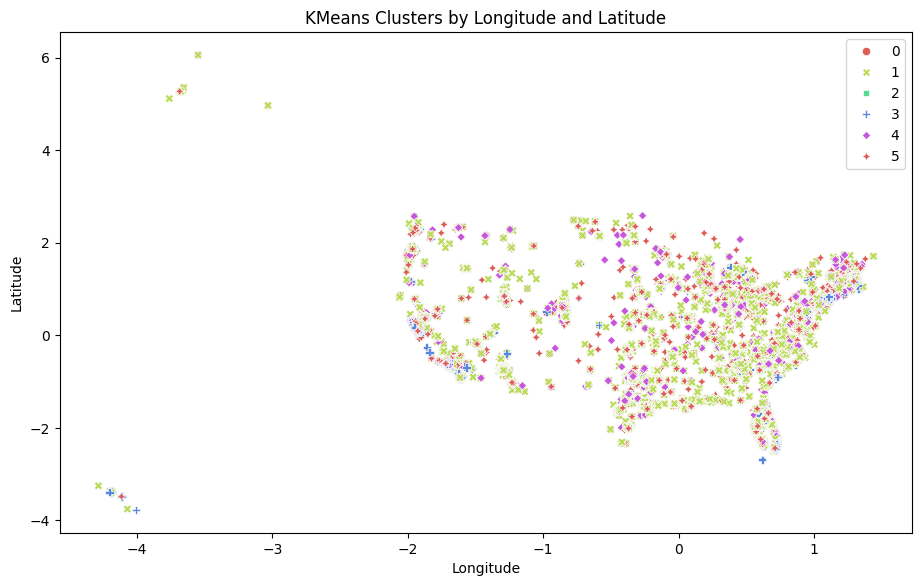

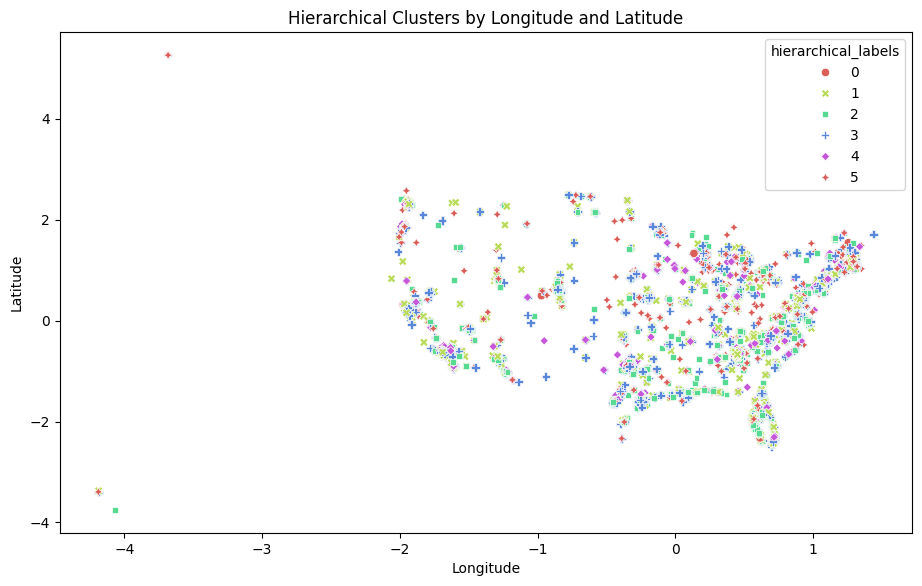

In [302]:
#drop the latitude and longitude columns
df_all_cluster = df_apartment_to_cluster.drop(columns=['latitude', 'longitude'])


#Loop through 1 to 10 clusters and get the inertia
inertia = []

for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_all_cluster)
    inertia.append(kmeans.inertia_)
    
#Plot the inertia
plt.plot(range(2, 30), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia by Number of Clusters')
plt.show()

#Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_all_cluster)

#Plot the clusters as a scatter plot of longitude vs latitude
sns.scatterplot(x=df_apartment_to_cluster['longitude'], y=df_apartment_to_cluster['latitude'], hue=kmeans.labels_, style=kmeans.labels_, palette='hls')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clusters by Longitude and Latitude')
plt.show()

#Create a hierarchical clustering model with 3 clusters
hierarchical = AgglomerativeClustering(n_clusters=6)

#Randomly sample 1000 rows for the hierarchical clustering
df_apartment_sample = df_all_cluster.sample(20000, random_state=42)

hierarchical.fit(df_apartment_sample)

#assign the labels to the original dataframe
df_apartment_sample['hierarchical_labels'] = hierarchical.fit_predict(df_apartment_sample)
df_apartment_sample['longitude'] = df_apartment_to_cluster['longitude']
df_apartment_sample['latitude'] = df_apartment_to_cluster['latitude']

df_apartment_sample.dropna(inplace=True)



#Plot the clusters as a scatter plot of longitude vs latitude
sns.scatterplot(x=df_apartment_sample['longitude'], 
                y=df_apartment_sample['latitude'], 
                hue=df_apartment_sample['hierarchical_labels'], 
                style=df_apartment_sample['hierarchical_labels'],
                palette='hls' )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical Clusters by Longitude and Latitude')
plt.show()



#### Clustering just on price and square footage

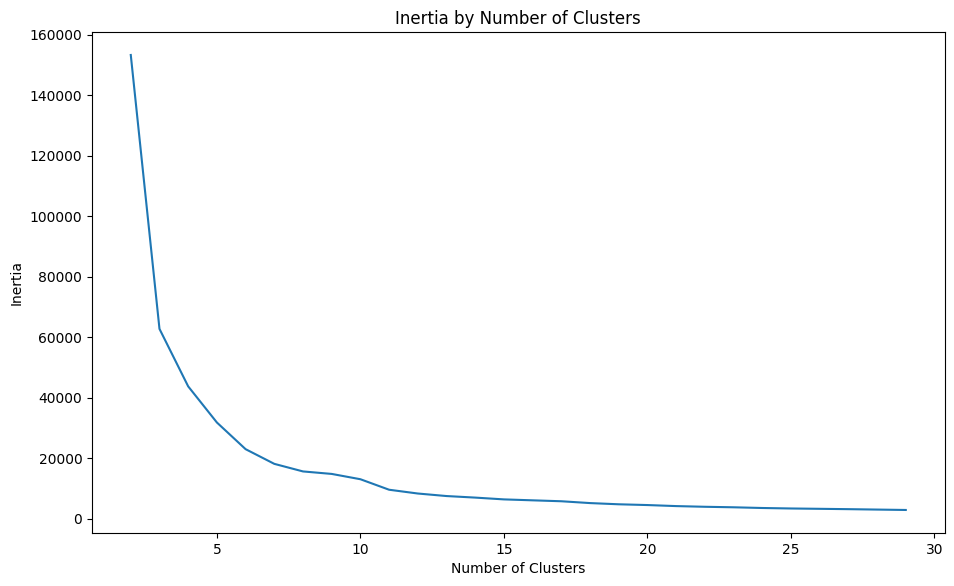

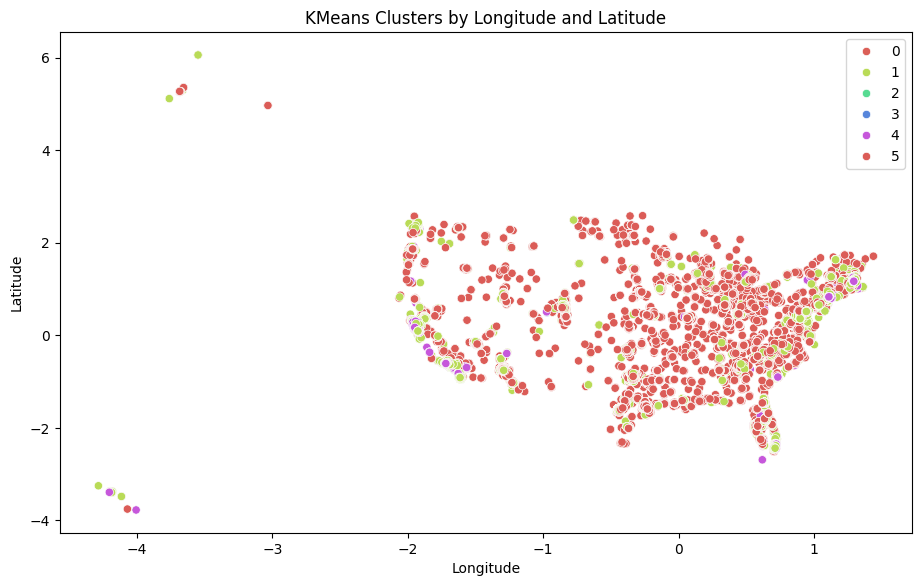

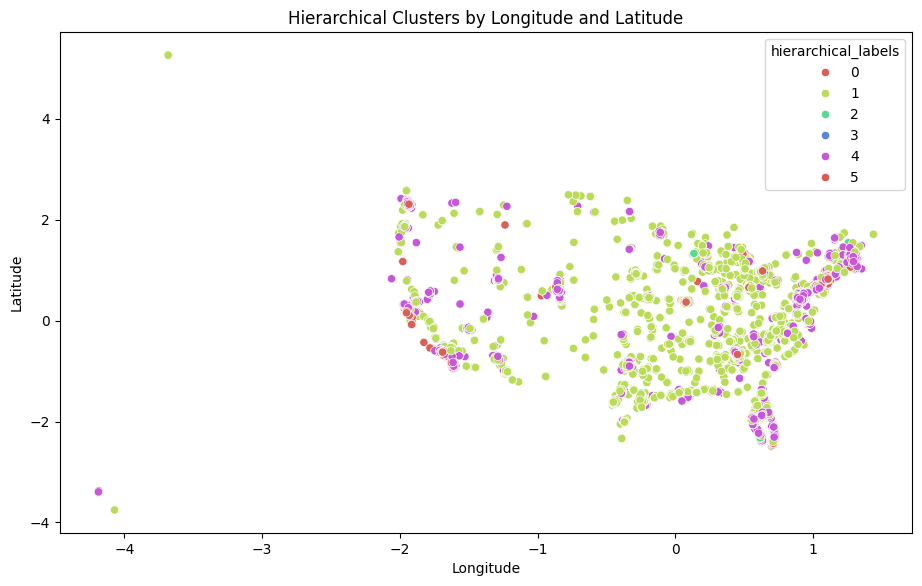

In [303]:
#drop the latitude and longitude columns
df_all_cluster = df_apartment_to_cluster.drop(columns=['latitude', 'longitude'])
df_all_cluster = df_all_cluster[['price','square_feet']]

#Loop through 1 to 10 clusters and get the inertia
inertia = []

for i in range(2, 30):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_all_cluster)
    inertia.append(kmeans.inertia_)
    
#Plot the inertia
plt.plot(range(2, 30), inertia)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Inertia by Number of Clusters')
plt.show()

#Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=6, random_state=42)
kmeans.fit(df_all_cluster)

#Plot the clusters as a scatter plot of longitude vs latitude
sns.scatterplot(x=df_apartment_to_cluster['longitude'], y=df_apartment_to_cluster['latitude'], hue=kmeans.labels_,palette='hls')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('KMeans Clusters by Longitude and Latitude')
plt.show()

#Create a hierarchical clustering model with 3 clusters
hierarchical = AgglomerativeClustering(n_clusters=6)

#Randomly sample 1000 rows for the hierarchical clustering
df_apartment_sample = df_all_cluster.sample(20000, random_state=42)

hierarchical.fit(df_apartment_sample)

#assign the labels to the original dataframe
df_apartment_sample['hierarchical_labels'] = hierarchical.fit_predict(df_apartment_sample)
df_apartment_sample['longitude'] = df_apartment_to_cluster['longitude']
df_apartment_sample['latitude'] = df_apartment_to_cluster['latitude']

df_apartment_sample.dropna(inplace=True)



#Plot the clusters as a scatter plot of longitude vs latitude
sns.scatterplot(x=df_apartment_sample['longitude'], 
                y=df_apartment_sample['latitude'], 
                hue=df_apartment_sample['hierarchical_labels'], 
                palette='hls' )
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hierarchical Clusters by Longitude and Latitude')
plt.show()

